# (28) Variograms -- Raw Data

**Motivation**: Plot raw data variograms using BrainSMASH code (average across time). <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, Latex

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def default_props_anesth(
        num_k: int = 7,
        perc: int = 15,
        **kwargs, ):
    mice = Mice(512)
    mice.set_kws(
        desc_ca2='preproc',
        desc_bold='rabies-hp',
    )
    props_base = {
        'mice': mice,
        'num_k': num_k,
        'task': 'rest',
        'perc': f'p{perc}-sample',
        'metric': 'pearson',
        'sv_props': {
            'match_using': 'gam',
            'match_metric': 'euclidean'},
        'graph_type': 'real',
        'kw_kmeans': {'n_init': 100},
        'verbose': False,
    }
    kwargs = setup_kwargs(props_base, kwargs)
    props_ca = {'mode': 'ca2', **kwargs}
    return mice, props_ca

## Prep

In [3]:
mice = Mice(512)
mice.setup_func_data()
print(mice.kws)

bs = Base(mice, mode='ca2')
kws_show = show_kws(7)
bands = {
    (0.0, 5.0): 'Unfiltered',
    (0.01, 5.0): 'HP',
    (0.01, 0.5): CAS,
    (0.5, 5.0): CAF,
}

pal = prepare_palette()
translation = {'BOLD': BOLD, 'CAS': CAS, 'CAF': CAF}

fig_dir = pjoin(fig_base_dir, 'rebuttal')
print(fig_dir)

{
    'task': 'rest',
    'exclude': True,
    'runs_only': True,
    'band_ca2': (0.01, 5.0),
    'band_bold': (0.01, 0.5),
    'desc_ca2': 'preproc',
    'desc_bold': 'rabies-hp'
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal

## Variogram

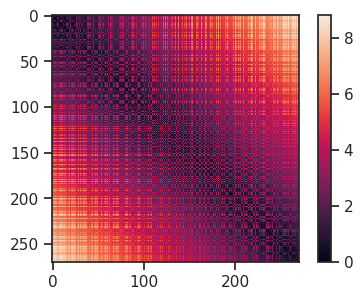

In [4]:
distances_left = np.load(
    pjoin(tmp_dir, 'euclidean_dists_left_hemis.npy'),
    allow_pickle=True,
).item()
d_square = np.zeros((len(bs.l_idxs),) * 2)
for (src, tgt), d in distances_left.items():
    d_square[bs.id2n[src], bs.id2n[tgt]] = d
d_square += d_square.T
d_square /= 100

plt.imshow(d_square)
plt.colorbar();

In [5]:
dr = np.load(
    pjoin(tmp_dir, 'degree_ranks.npy'),
    allow_pickle=True,
).item()
{k: (np.nanmin(v), np.nanmax(v)) for k, v in dr.items()}

{
    'BOLD': (0.21269394878330333, 0.7681680279339376),
    'CAS': (0.07455426045514849, 0.9319673110142711),
    'CAF': (0.009846819005735, 0.964751401485692)
}

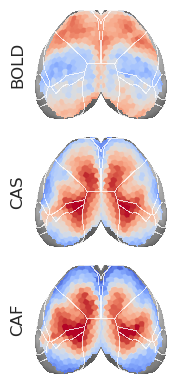

In [6]:
bs.show(
    dr, vmin=0, vmax=0.9, figsize=(2, 4),
    label_fontsize=12, label_pad=7,
    cmap='coolwarm', cbar=False,
);

## BrainSMASH

In [7]:
sys.path.insert(0, os.path.join(git_dir, 'brainsmash'))
from brainsmash.mapgen.base import Base as Brainsmash_BS

In [9]:
gamma = {}
for k, d in dr.items():
    x = d[bs.l_idxs]
    good = ~np.isnan(x)
    x = x[good]

    base = Brainsmash_BS(x, d_square[good][:, good])
    gamma[k] = base.compute_smooth_variogram(x)

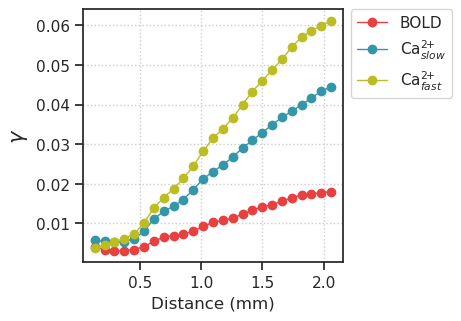

In [10]:
fig, ax = create_figure(1, 1, (6.0, 3.0), sharey='all', layout='constrained')
for i, mode in enumerate(gamma):
    ax.plot(
        base.h,
        gamma[mode],
        color=pal[translation[mode]],
        label=translation[mode],
        marker='o',
        lw=1,
    )
ax.legend()
ax.set_ylabel(r'$\gamma$', fontsize=15)
ax.set_xlabel('Distance (mm)')
move_legend(ax, (1., 1.03))
ax.grid()

fig.savefig(
    pjoin(fig_dir, f"variogram_brainsmash_degree.pdf"),
    bbox_inches='tight',
)
plt.show()

## Raw data

In [108]:
def _fit_gamma(data, seed=0, verbose=False, shuffle=False):
    gamma = []
    for t in tqdm(range(data.shape[1]), disable=not verbose):
        x = data[bs.l_idxs, t]
        good = ~np.isnan(x)
        if not good.sum():
            continue
        x = x[good]

        if shuffle:
            rng = get_rng(seed)
            rng.shuffle(x)

        base = Brainsmash_BS(x, d_square[good][:, good], seed=seed)
        gamma.append(base.compute_smooth_variogram(x))

    gamma = np.stack(gamma)
    return gamma


def _normalize_space_time(data):
    data = sp_stats.zscore(data, axis=1)
    mu = np.nanmean(data, axis=0, keepdims=True)
    sd = np.nanstd(data, axis=0, keepdims=True)
    data = (data - mu) / sd
    return data

In [113]:
key = 'sub-SLC01_ses-1_run-3'

In [114]:
data = Base(mice, key=key, mode='bold-lite', prep_data=True)
data = _normalize_space_time(data.data)
# data = sp_stats.zscore(data.data, axis=1)
data.shape

(540, 477)

In [115]:
gamma_shuffled = _fit_gamma(data, shuffle=True)
gamma_raw = _fit_gamma(data)

gamma_shuffled.shape, gamma_raw.shape

((477, 25), (477, 25))

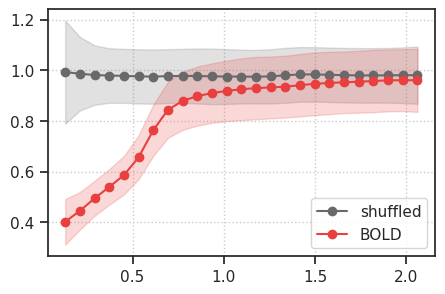

In [116]:
mu = gamma_shuffled.mean(0)
sd = gamma_shuffled.std(0)
plt.plot(base.h, mu, color='dimgrey', marker='o', label='shuffled')
plt.fill_between(base.h, mu - sd, mu + sd, color='dimgrey', alpha=0.2)

mu = gamma_raw.mean(0)
sd = gamma_raw.std(0)
plt.plot(base.h, mu, color=pal[BOLD], marker='o', label=BOLD)
plt.fill_between(base.h, mu - sd, mu + sd, color=pal[BOLD], alpha=0.2)

plt.grid()
plt.legend(loc='lower right')
plt.show()

In [117]:
mice.set_kws(band_ca2=(0.01, 0.5))

In [118]:
data = Base(mice, key=key, mode='ca2', prep_data=True)
data = _normalize_space_time(data.data)
data.shape

(540, 4420)

In [119]:
gamma_shuffled = _fit_gamma(data, shuffle=True)
gamma_raw = _fit_gamma(data)

gamma_shuffled.shape, gamma_raw.shape

((4420, 25), (4420, 25))

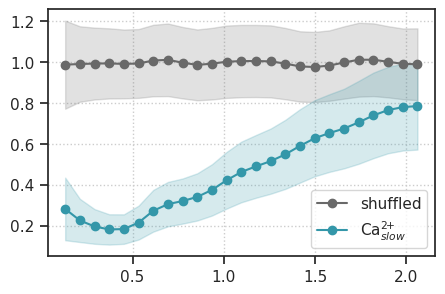

In [120]:
mu = gamma_shuffled.mean(0)
sd = gamma_shuffled.std(0)
plt.plot(base.h, mu, color='dimgrey', marker='o', label='shuffled')
plt.fill_between(base.h, mu - sd, mu + sd, color='dimgrey', alpha=0.2)

mu = gamma_raw.mean(0)
sd = gamma_raw.std(0)
plt.plot(base.h, mu, color=pal[CAS], marker='o', label=CAS)
plt.fill_between(base.h, mu - sd, mu + sd, color=pal[CAS], alpha=0.2)

plt.grid()
plt.legend(loc='lower right')
plt.show()

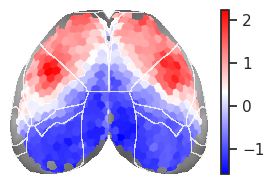

In [121]:
t = 1200
bs.show(
    data[:, t],
    figsize=(3, 2),
    vmin=np.nanmin(data[:, t]),
    vmax=np.nanmax(data[:, t]),
    cmap='bwr',
    cbar=True,
);

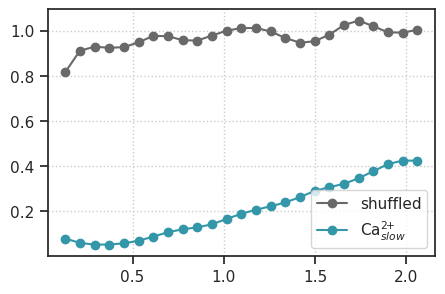

In [122]:
plt.plot(base.h, gamma_shuffled[t], color='dimgrey', marker='o', label='shuffled')
plt.plot(base.h, gamma_raw[t], color=pal[CAS], marker='o', label=CAS)
plt.legend(loc='lower right')
plt.grid()
plt.show()

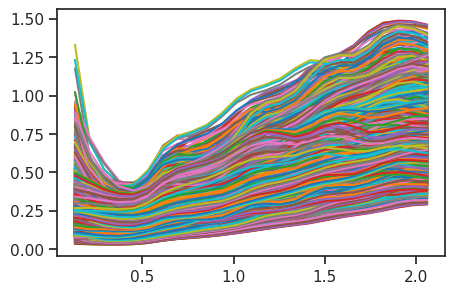

In [128]:
plt.plot(base.h, gamma_raw.T);

In [205]:
ids = np.argsort(gamma_raw[:, 0])

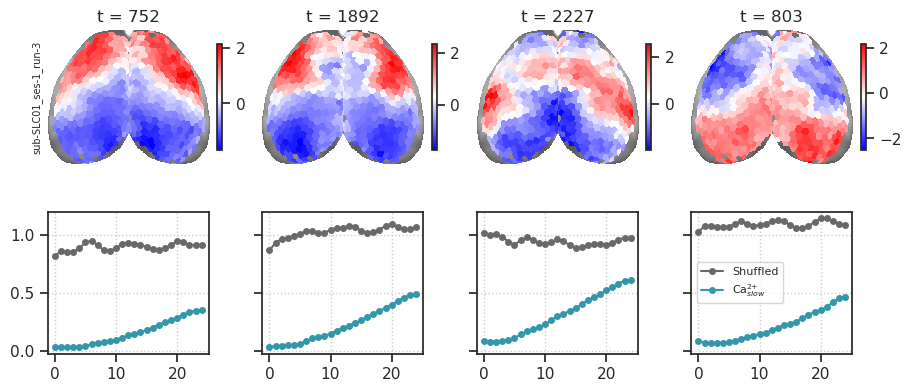

In [272]:
time_ids = [ids[i] for i in [0, 1, 160, 170]]
x2p = [data[:, t] for t in time_ids]
x2p += [np.isfinite(x2p[0])]
x2p = np.stack(x2p)
x2p, top = bs.trim2d(bs.project_vec(x2p))

fig, axes = create_figure(2, 4, (9.0, 4.0), sharey='row', layout='constrained', height_ratios=[1.5, 1])
for i, t in enumerate(time_ids):
    ax = axes[0, i]
    ax.set_title(f't = {t}')
    ax.imshow(mwh(top == 0, top), cmap='Greys_r')
    im = ax.imshow(mwh(~x2p[-1].astype(bool), x2p[i]), cmap='bwr')
    plt.colorbar(im, ax=ax, shrink=0.5)
    
    ax = axes[1, i]
    ax.plot(gamma_shuffled[t], marker='o', markersize=4, color='dimgrey', label='Shuffled')
    ax.plot(gamma_raw[t], marker='o', markersize=4, color=pal[CAS], label=CAS)
    if i == 3:
        ax.legend(fontsize=8)
    ax.grid()

axes[0, 0].set_ylabel(key, fontsize=7)
remove_ticks(axes[0])
plt.show()

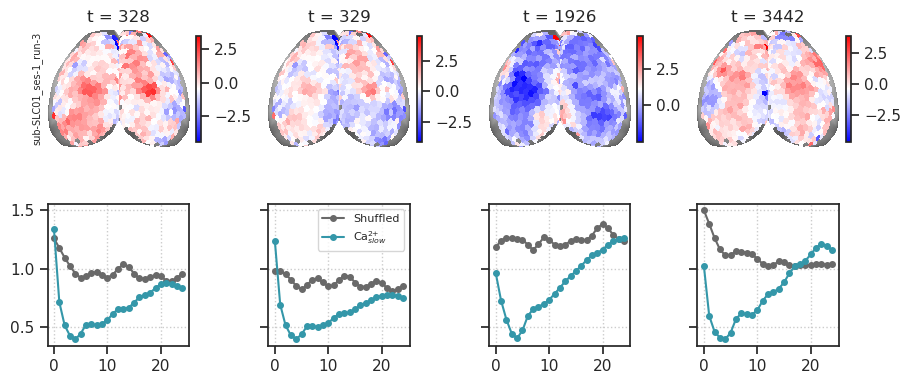

In [275]:
time_ids = [ids[i] for i in [-1, -2, -6, -4]]
x2p = [data[:, t] for t in time_ids]
x2p += [np.isfinite(x2p[0])]
x2p = np.stack(x2p)
x2p, top = bs.trim2d(bs.project_vec(x2p))

fig, axes = create_figure(2, 4, (9.0, 4.0), sharey='row', layout='constrained', height_ratios=[1.5, 1])
for i, t in enumerate(time_ids):
    ax = axes[0, i]
    ax.set_title(f't = {t}')
    ax.imshow(mwh(top == 0, top), cmap='Greys_r')
    im = ax.imshow(mwh(~x2p[-1].astype(bool), x2p[i]), cmap='bwr')
    plt.colorbar(im, ax=ax, shrink=0.5)
    
    ax = axes[1, i]
    ax.plot(gamma_shuffled[t], marker='o', markersize=4, color='dimgrey', label='Shuffled')
    ax.plot(gamma_raw[t], marker='o', markersize=4, color=pal[CAS], label=CAS)
    if i == 1:
        ax.legend(fontsize=8)
    ax.grid()

axes[0, 0].set_ylabel(key, fontsize=7)
remove_ticks(axes[0])
plt.show()

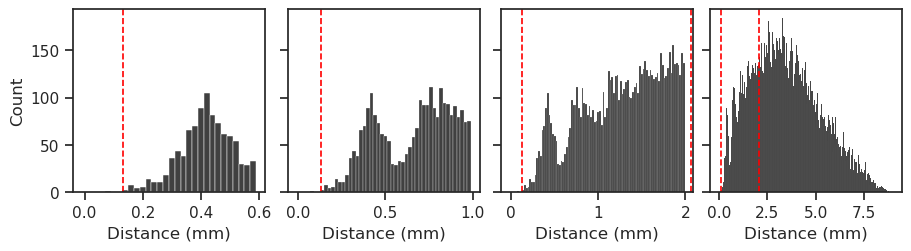

In [350]:
scale = 50

fig, axes = create_figure(1, 4, (9, 2.4), sharey='all', layout='constrained')
for i, lim in enumerate([0.6, 1, 2, 9]):
    ax = axes[i]
    ax.set_xlabel('Distance (mm)')

    bins = np.linspace(0, lim, int(np.round(lim * scale + 1)))
    bins -= 1 / scale / 2
    
    sns.histplot(
        sp_dist.squareform(d_square),
        color='black',
        bins=bins,
        ax=ax,
    )
    ax.axvline(min(base.h), color='red', ls='--', lw=1.2)
    if i > 1:
        ax.axvline(max(base.h), color='red', ls='--', lw=1.2)

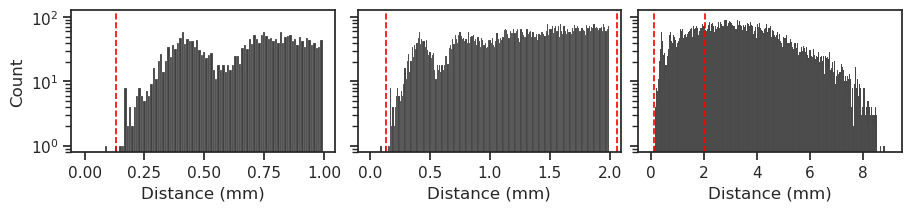

In [304]:
scale = 100

fig, axes = create_figure(1, 3, (9, 2), sharey='all', layout='constrained')
for i, lim in enumerate([1, 2, 9]):
    ax = axes[i]
    ax.set_xlabel('Distance (mm)')

    bins = np.linspace(0, lim, lim * scale + 1)
    bins -= 1 / scale / 2
    
    sns.histplot(
        sp_dist.squareform(d_square),
        color='black',
        bins=bins,
        ax=ax,
    )
    ax.axvline(min(base.h), color='red', ls='--', lw=1.2)
    if i > 0:
        ax.axvline(max(base.h), color='red', ls='--', lw=1.2)
    ax.set_yscale('log')

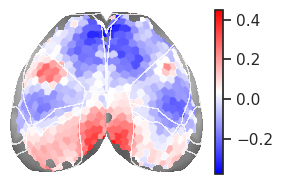

In [336]:
i = 21
x2p = np.mean(data[:, ids[i * 100: (i + 1) * 100]], -1)

bs.show(
    x2p,
    figsize=(3, 2),
    vmin=np.nanmin(x2p),
    vmax=np.nanmax(x2p),
    cmap='bwr',
    cbar=True,
);

In [337]:
props = {
    'mice': mice,
    'mode': 'bold-lite',
    'task': 'rest',
    'prep_data': True,
}
kws = {
    'task': task,
    f"band_{bold-lite}": b,
    f"desc_{args.mode}": args.desc,
}
mice.setup_func_data(**kws)

In [338]:
key

'sub-SLC01_ses-1_run-3'

In [339]:
net = Network(key=key, **props)

In [340]:
net.name()

'n-512*3_pearson_rest_bold-lite-rabies-hp_bp(0.01,0.5)_sub-SLC01_ses-1_run-3'

In [341]:
mode = 'ca2'
desc = 'sigma1.0'
kws = {f"desc_{mode}": desc}

In [343]:
mice.setup_preproc_data(**kws)

In [346]:
f = mice.ca_preproc['sub-SLC10_ses-3_run-7']
vars(f)

{
    'cfg': <model.configuration.Config object at 0x7f186c050400>,
    '_patterns': [
        '_desc-sigma1.0_',
        'ca2',
        'run-7',
        'ses-3',
        'space-individual',
        'sub-SLC10'
    ],
    'key': 'sub-SLC10_ses-3_run-7',
    'mode': 'ca2',
    'space': 'individual',
    'npy_dir': None,
    'nii_file': None,
    'npy_file': None,
    'dtype': <class 'float'>,
    '_npy': None,
    'shape': None,
    'task': None
}

In [347]:
f.nii_file

## Smoothened Ca data

In [178]:
proj = bs.trim2d(bs.project_vec(data[:, t]))[0][0]

In [179]:
x = sp_img.gaussian_filter(proj, sigma=5)

<matplotlib.image.AxesImage object at 0x7f155b650c40>

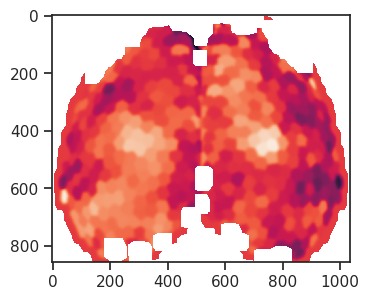

In [180]:
plt.imshow(mwh(x == 0, x))

In [181]:
mice.setup_preproc_data()

In [187]:
img = mice.ca_preproc[key].load_ants()
raw = img.numpy()[..., 0, :]
mask = np.mean(np.abs(raw), -1) > 0
gs = raw[mask].mean(0)

<matplotlib.lines.Line2D object at 0x7f155b110490>

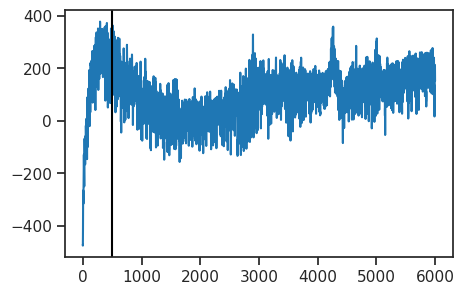

In [204]:
plt.plot(gs)
plt.axvline(500, color='k')

In [193]:
snr = np.mean(raw, -1) / np.std(raw, -1)

<matplotlib.image.AxesImage object at 0x7f155b1b80d0>

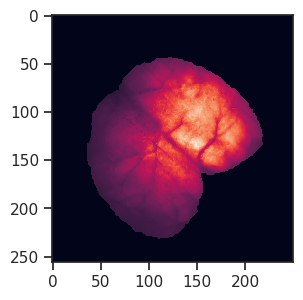

In [195]:
plt.imshow(np.std(raw, -1))

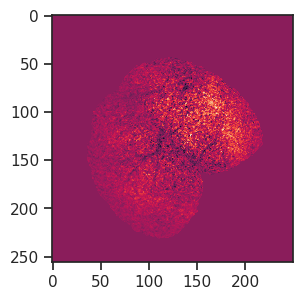

In [188]:
plt.imshow(raw[..., 1900]);

In [196]:
raw_zs = sp_stats.zscore(raw, -1)

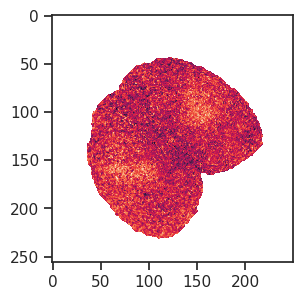

In [199]:
plt.imshow(raw_zs[..., 1600]);

## Plot sample timepoints

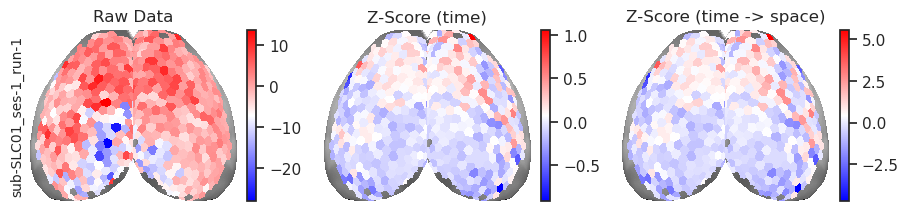

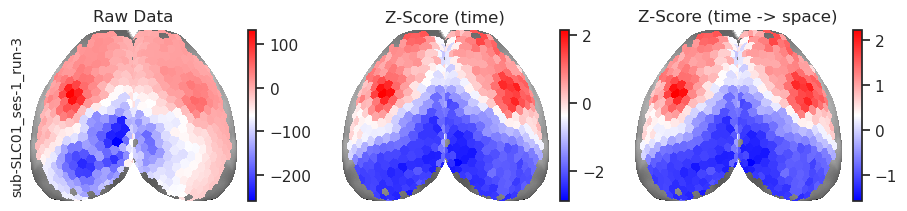

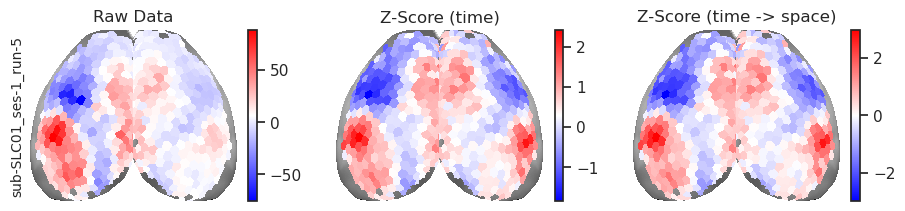

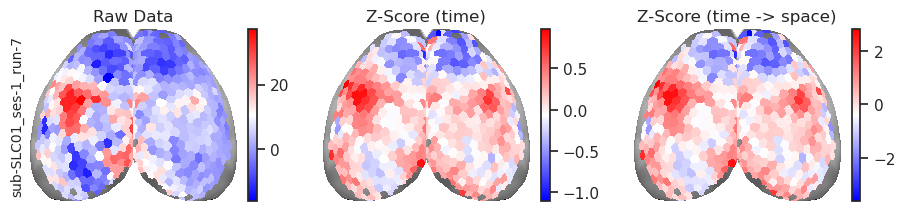

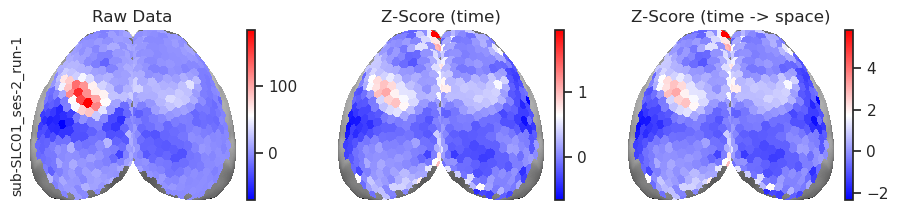

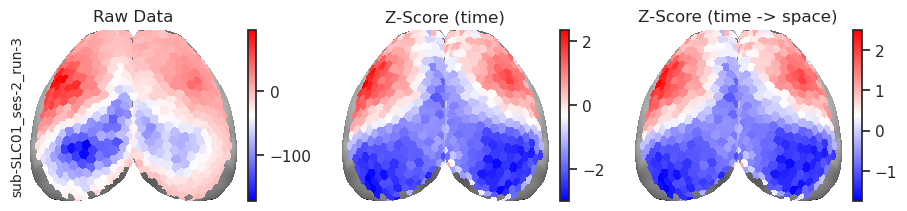

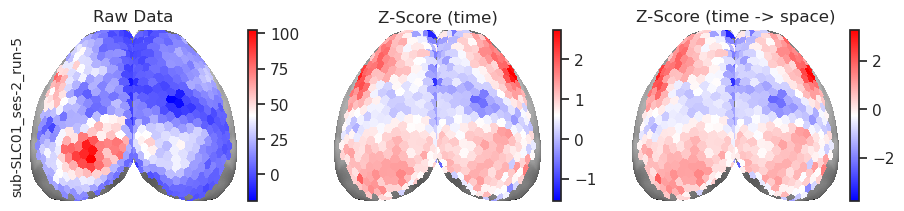

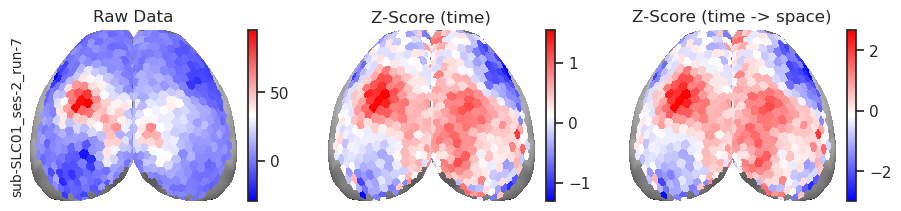

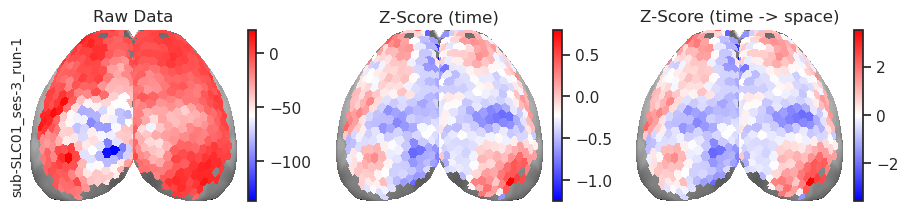

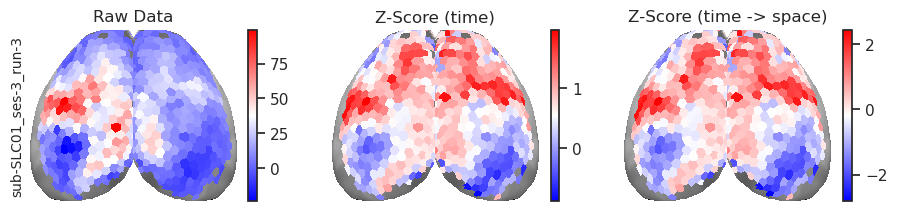

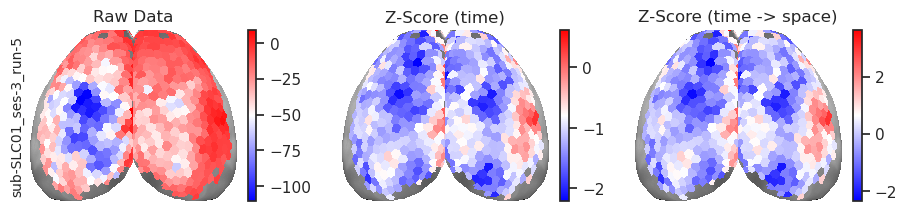

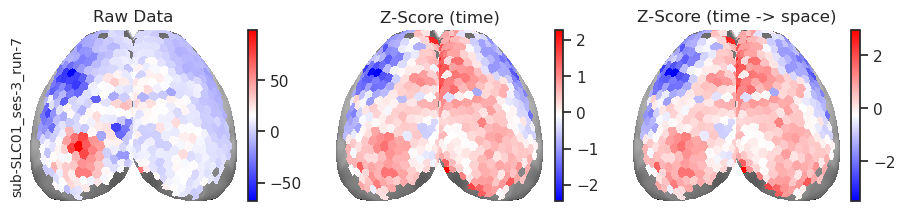

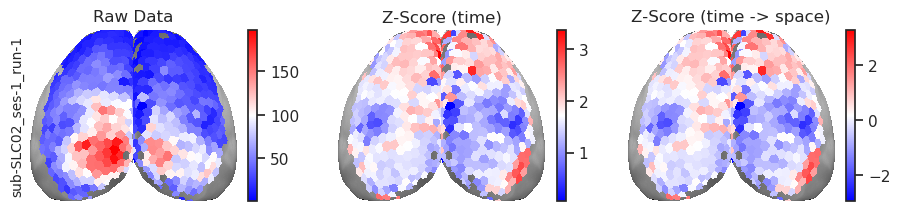

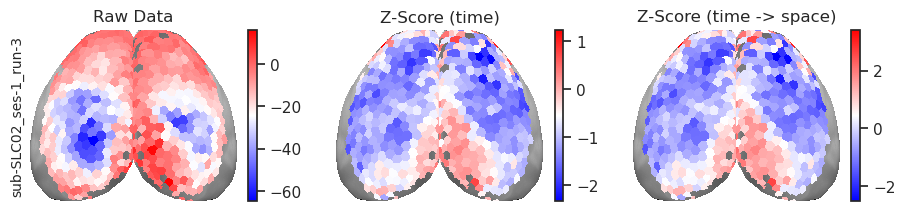

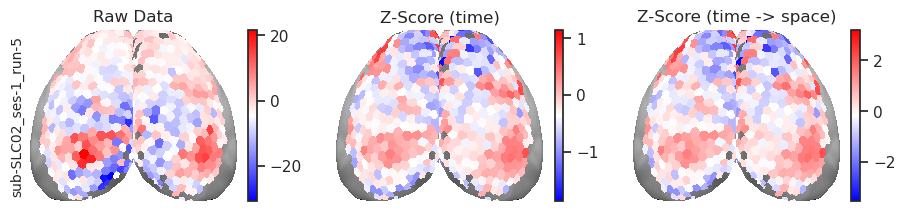

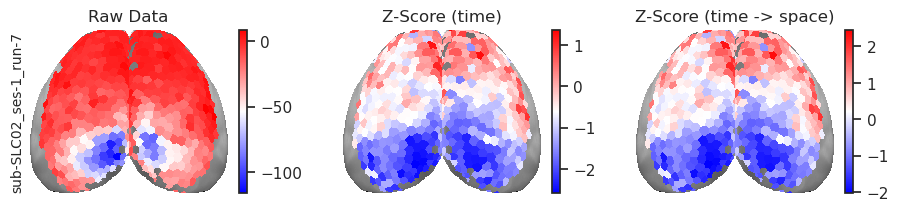

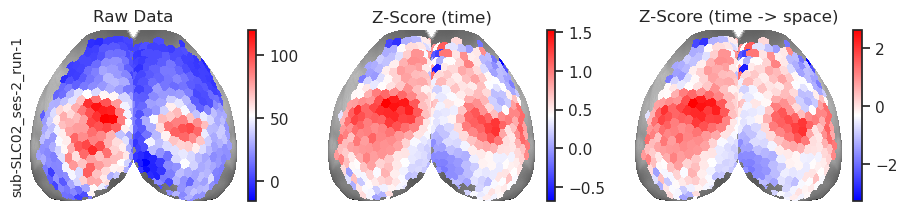

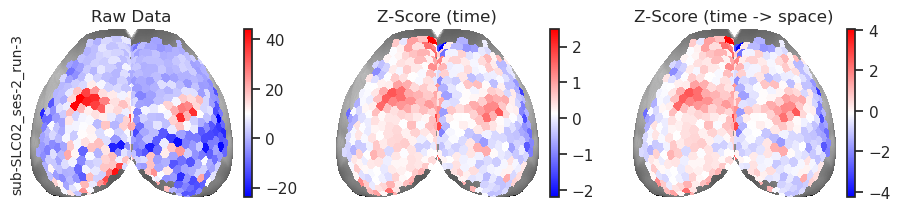

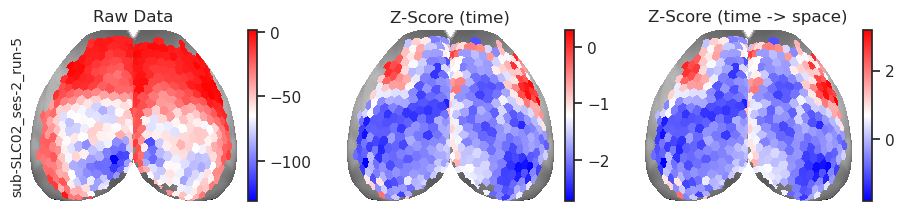

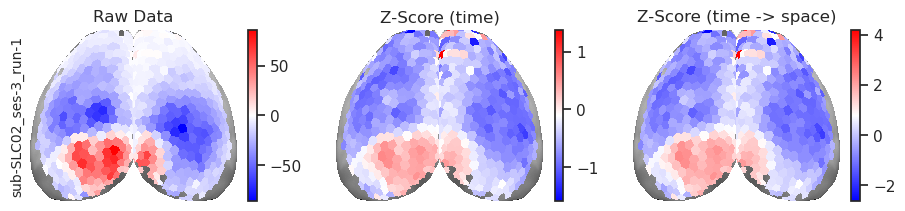

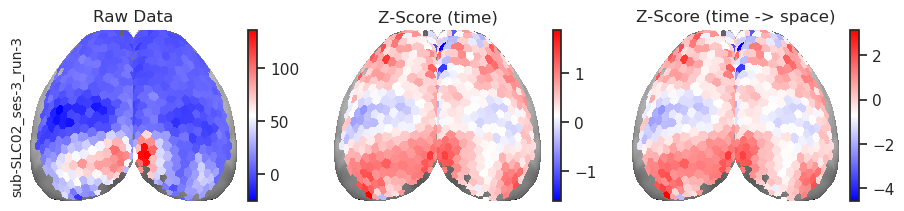

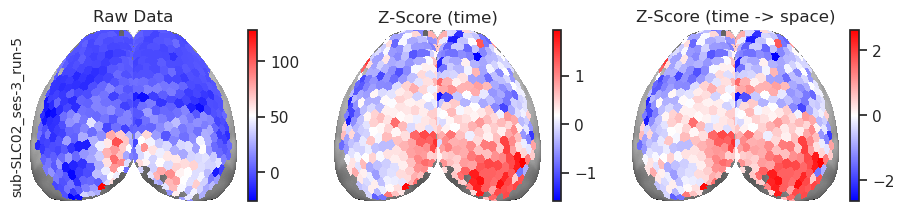

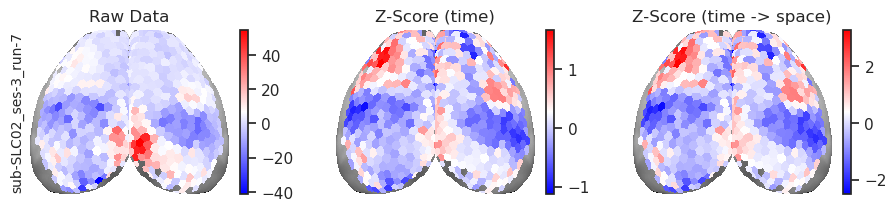

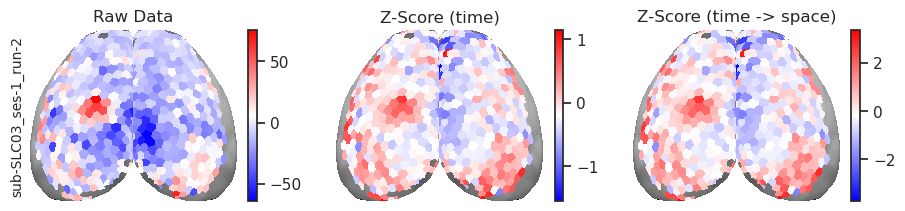

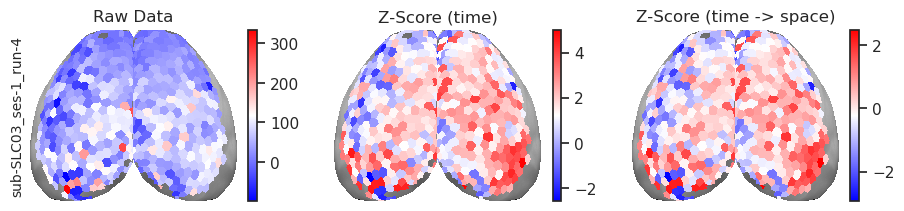

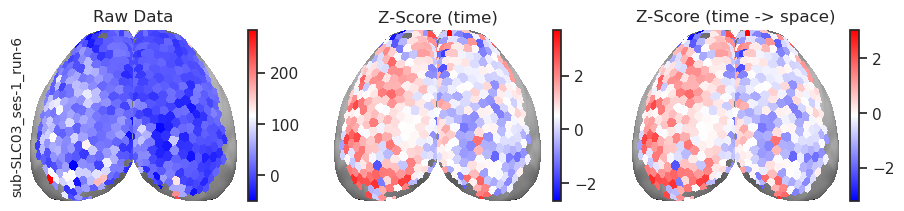

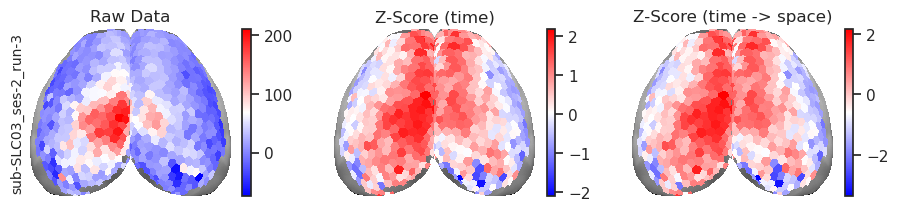

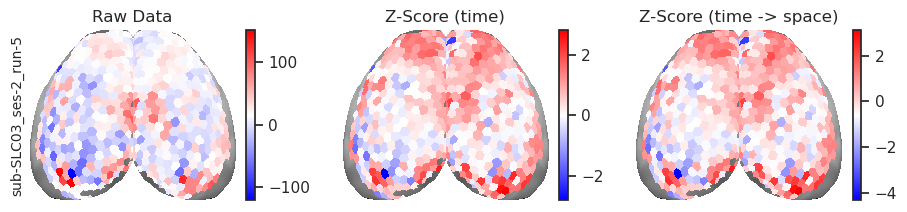

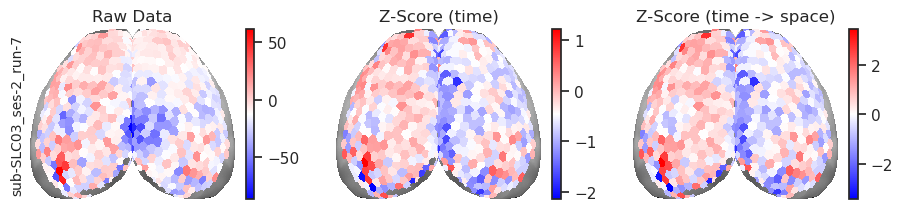

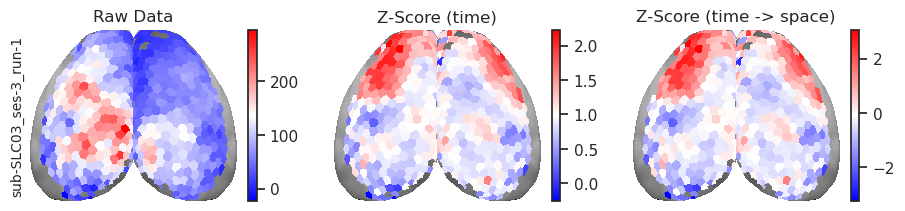

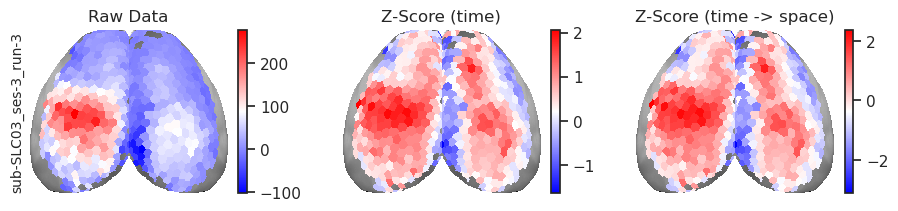

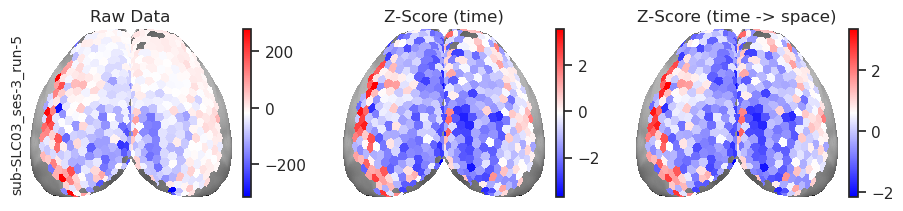

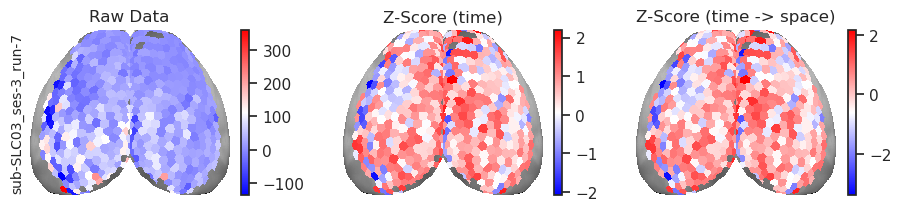

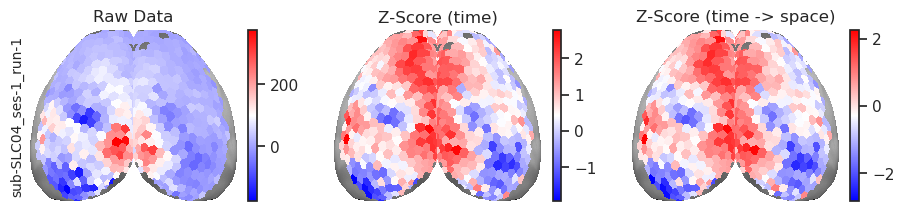

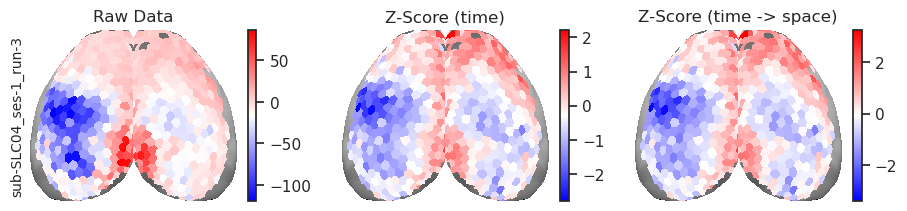

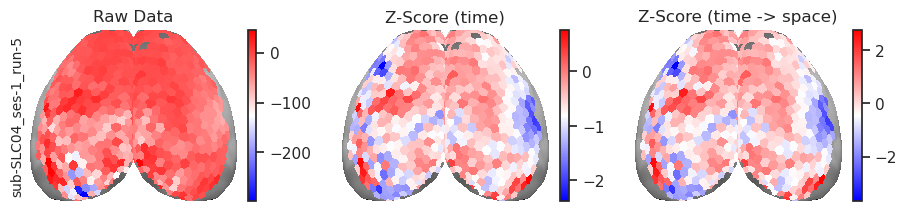

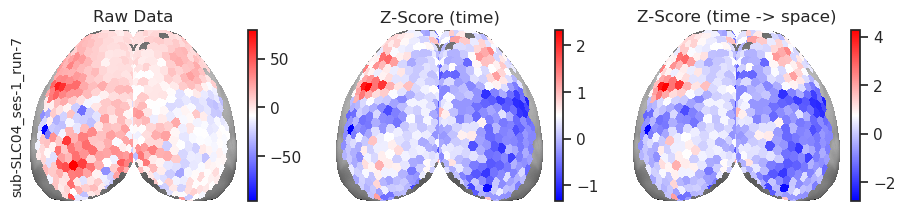

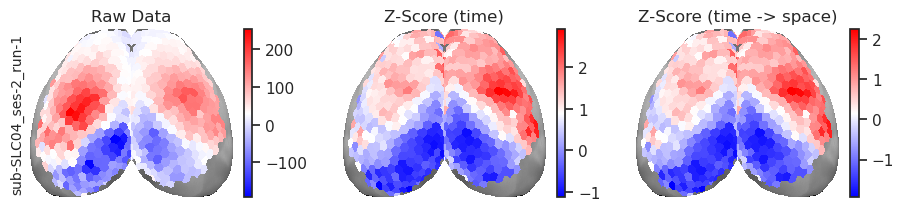

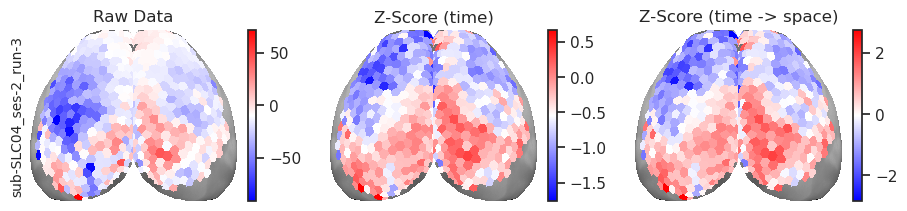

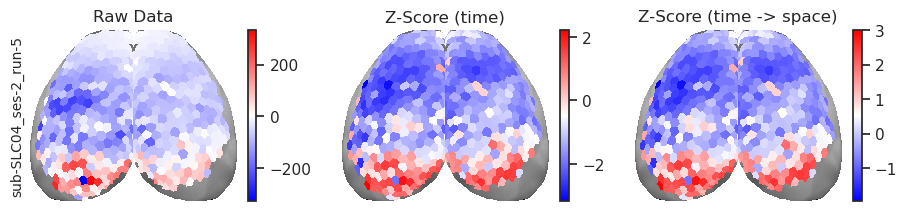

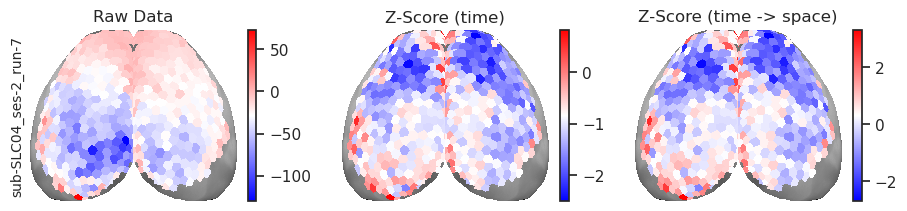

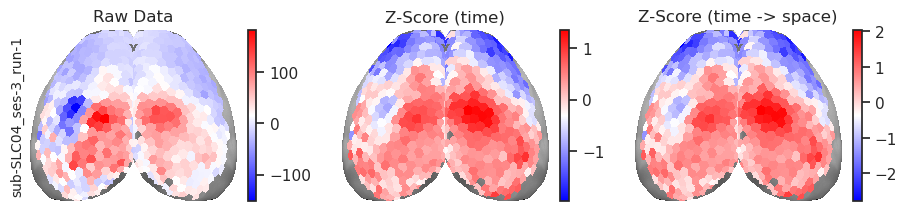

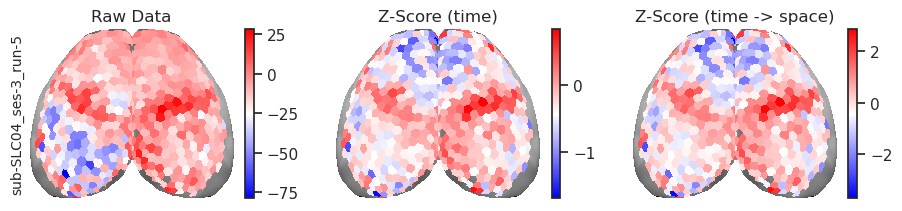

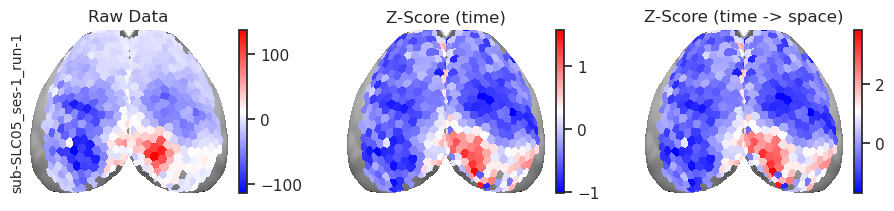

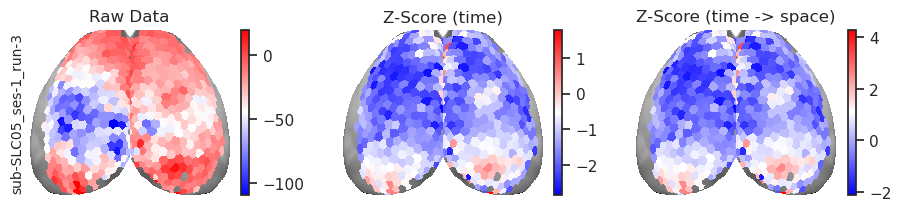

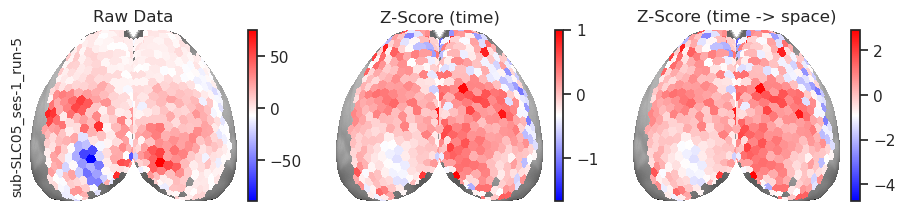

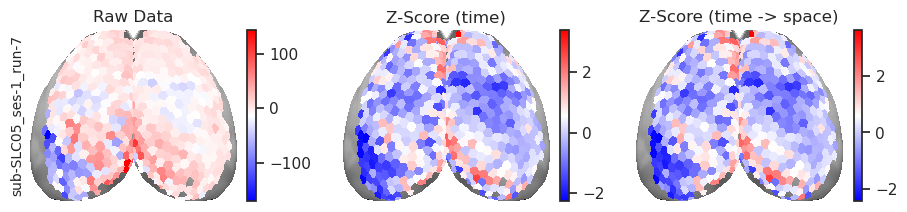

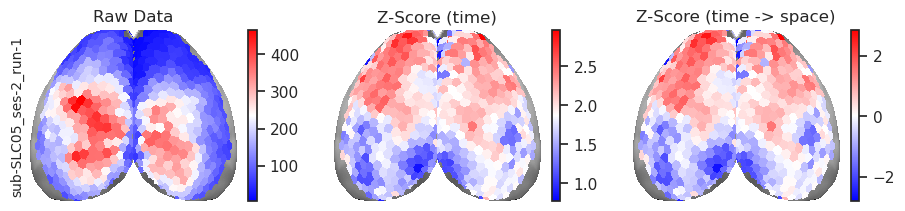

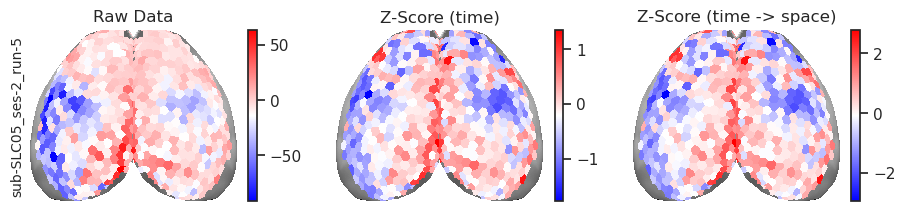

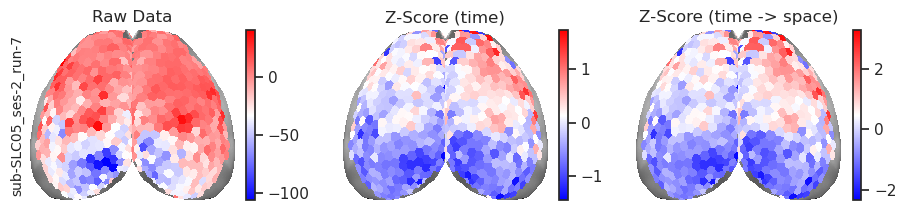

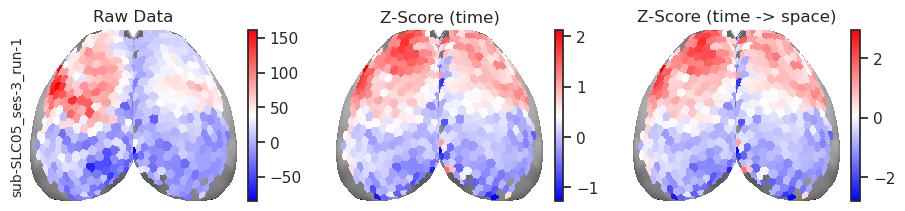

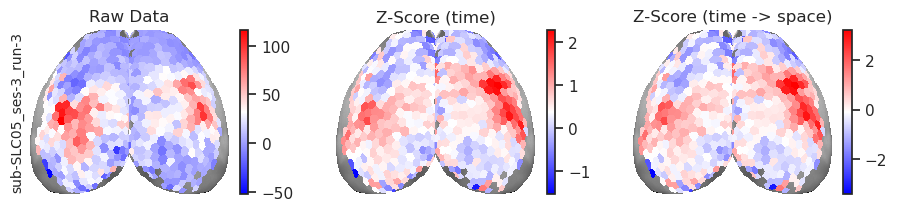

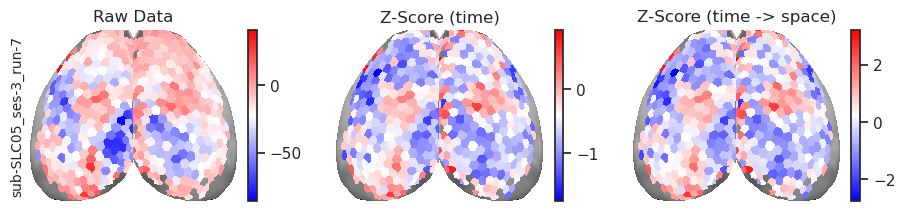

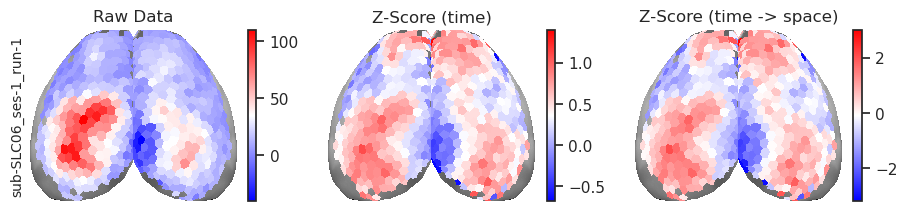

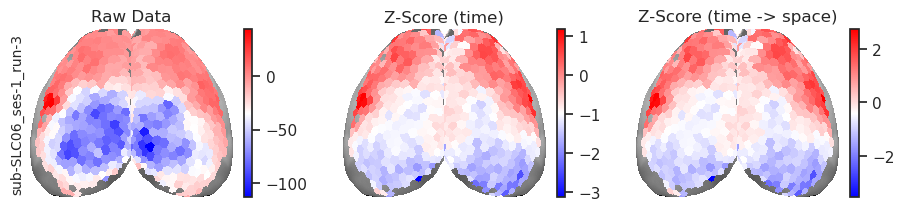

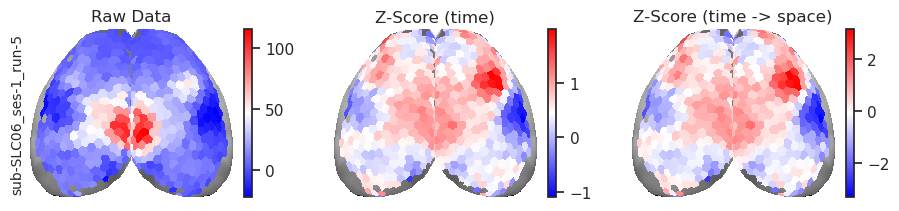

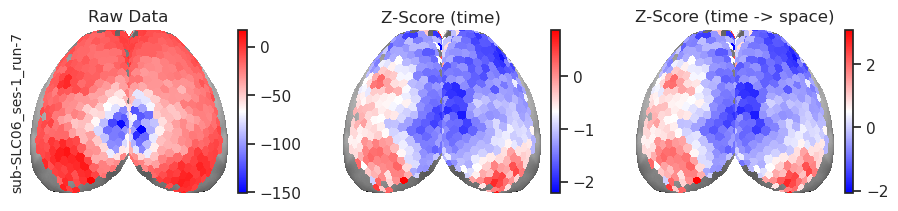

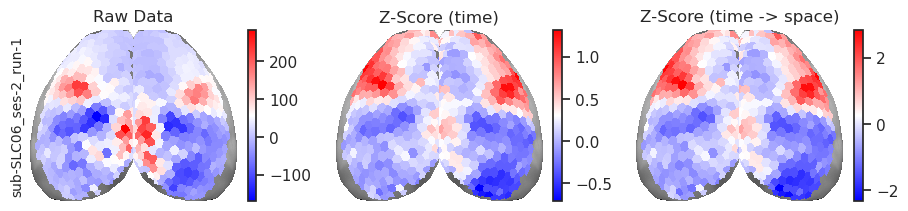

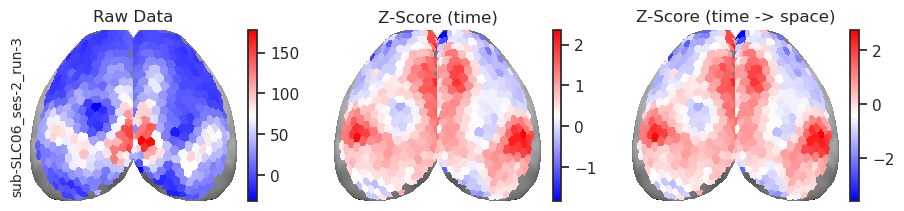

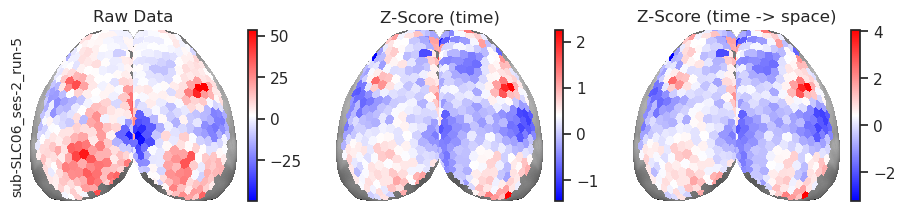

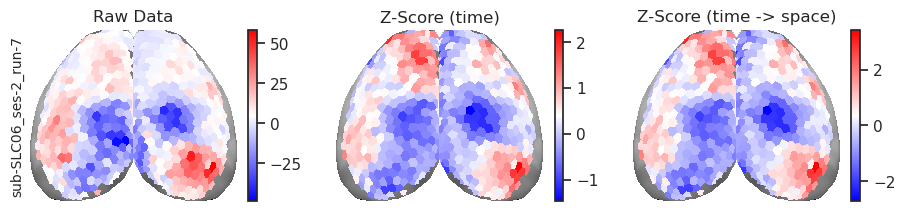

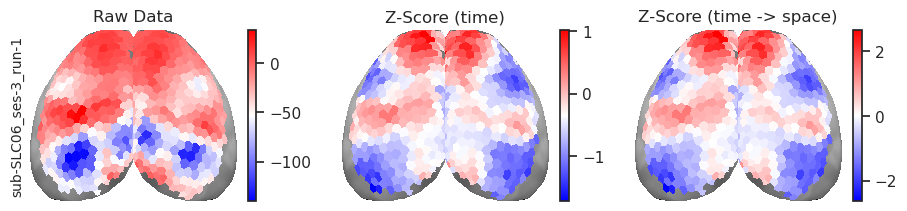

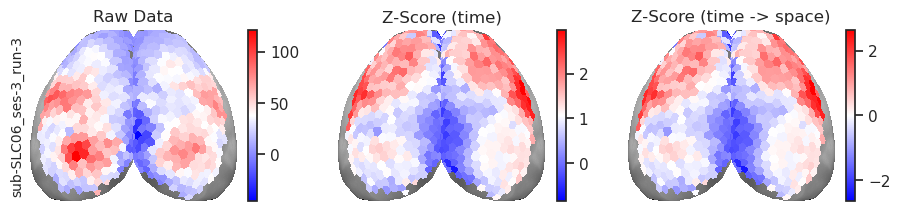

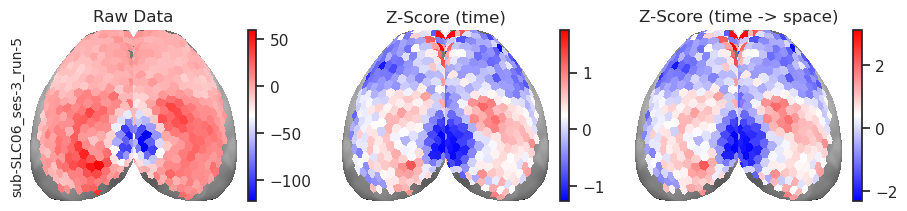

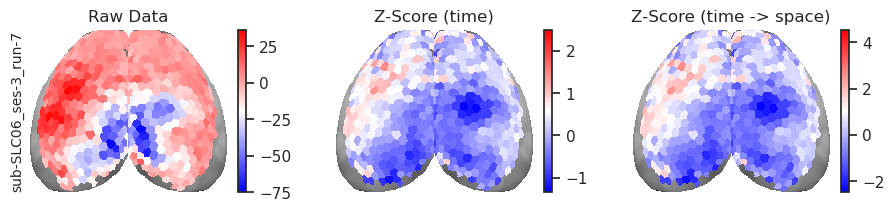

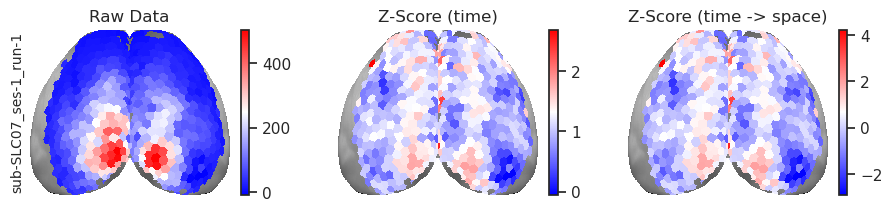

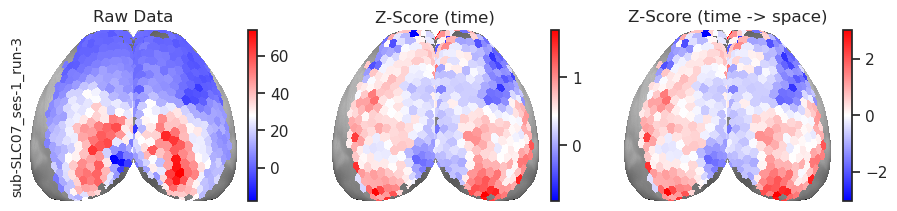

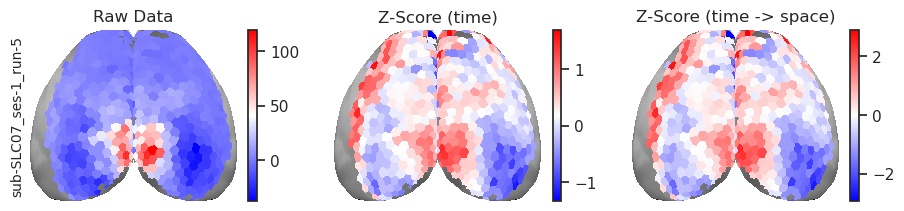

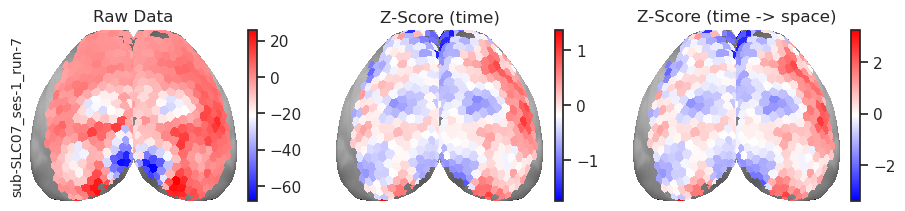

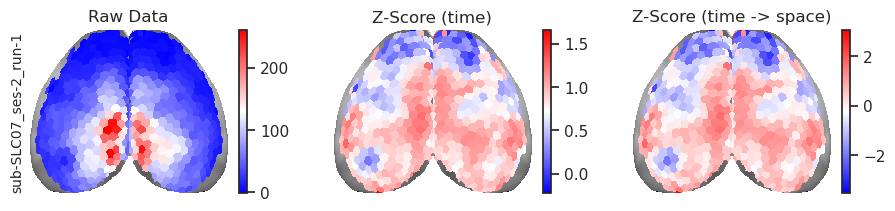

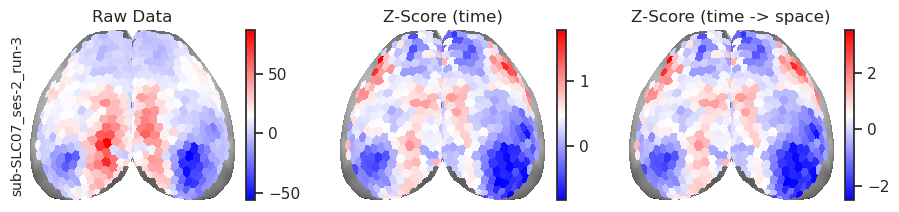

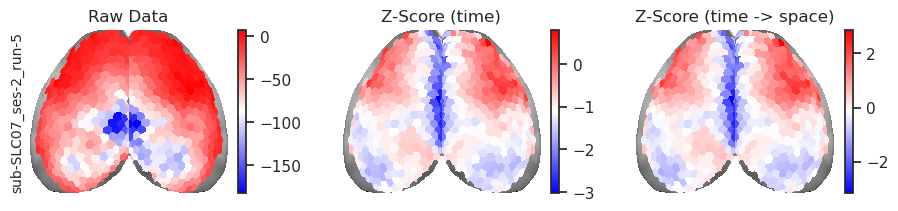

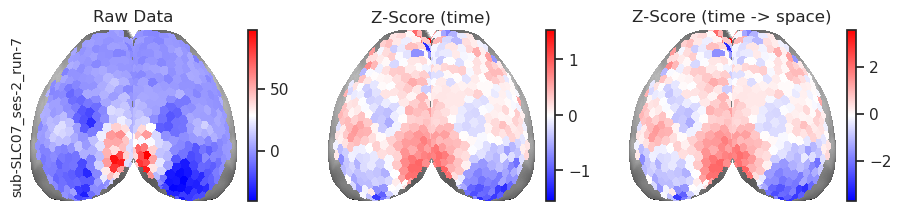

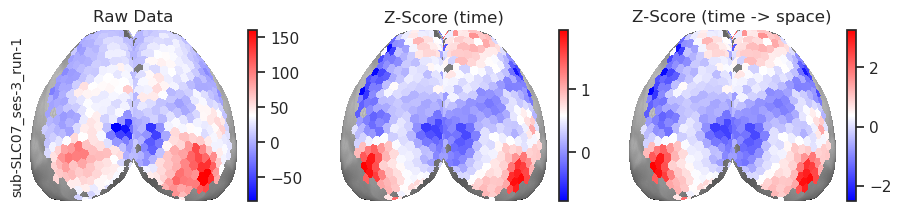

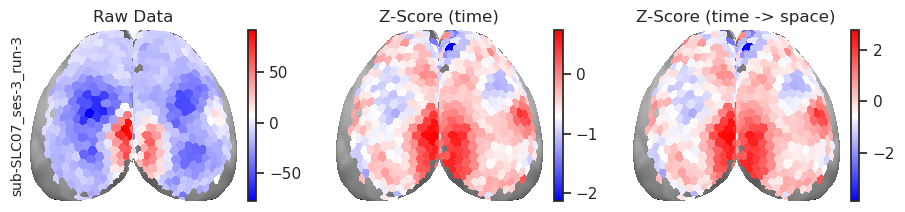

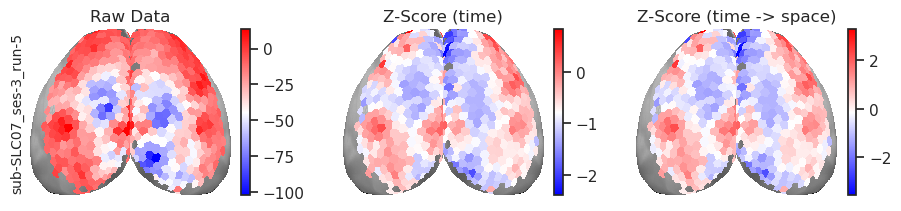

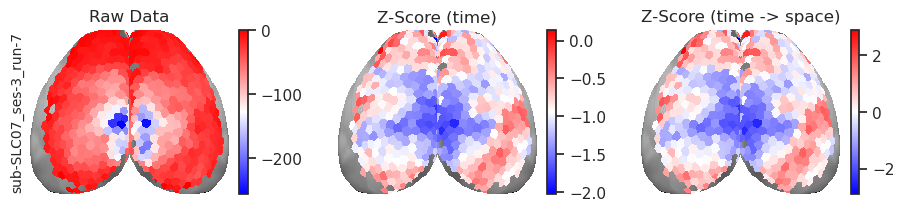

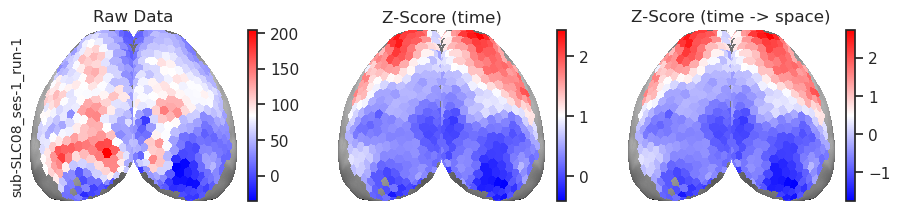

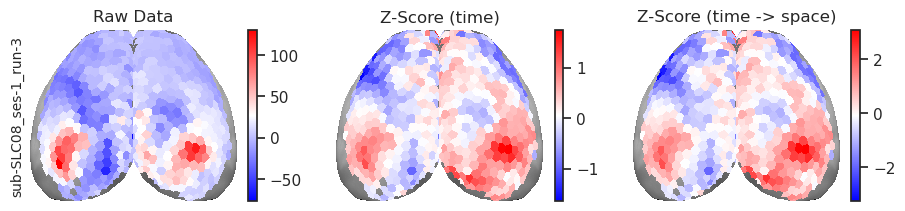

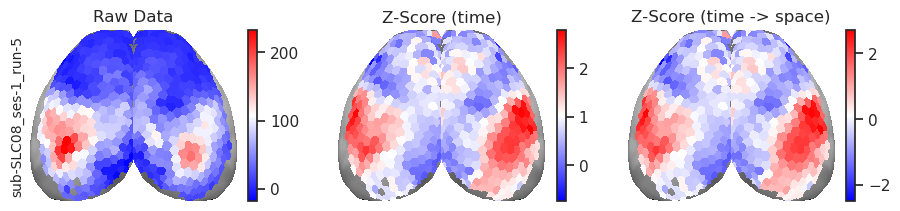

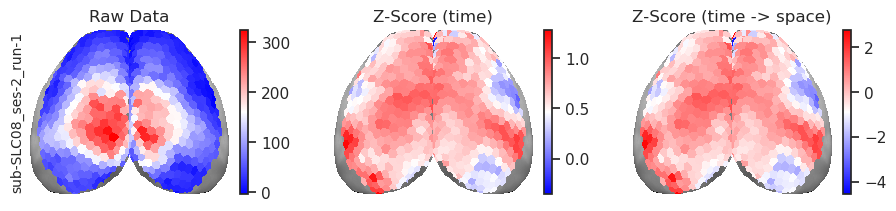

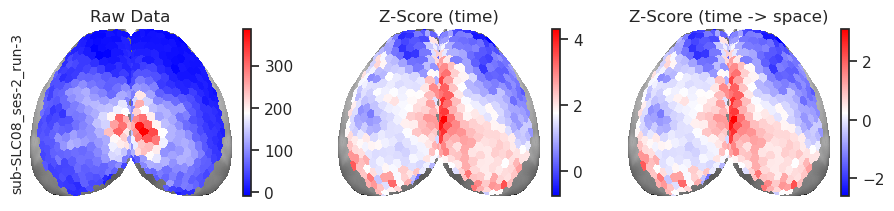

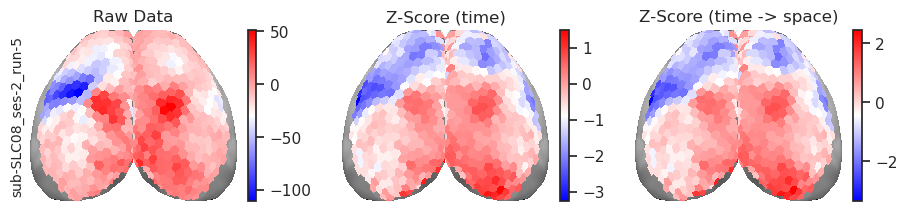

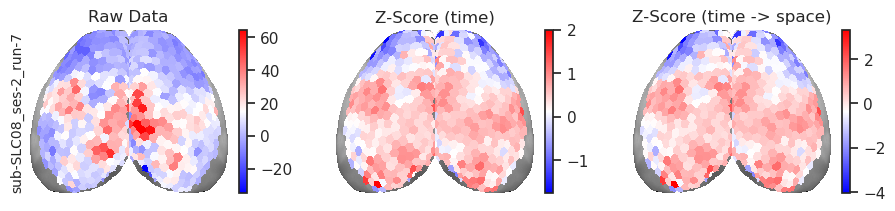

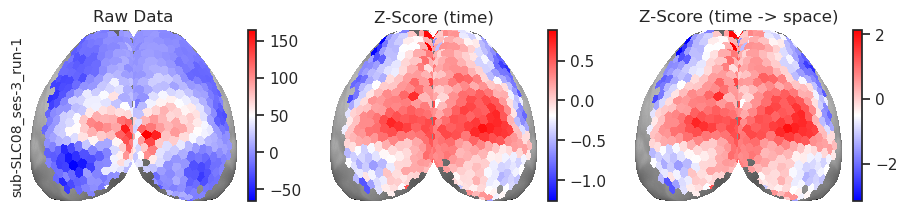

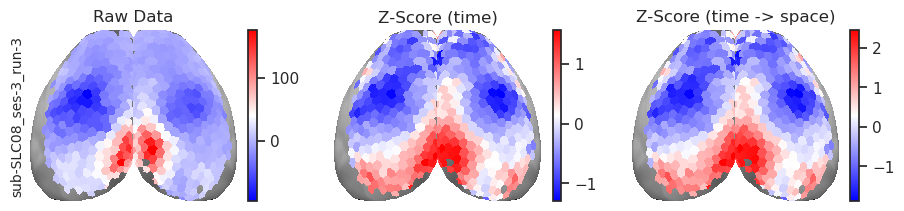

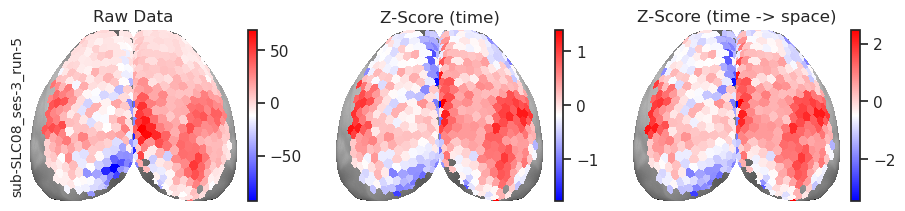

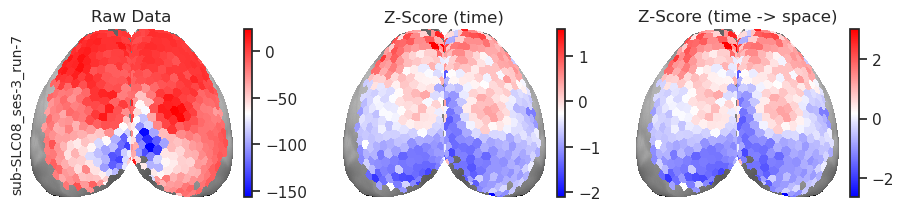

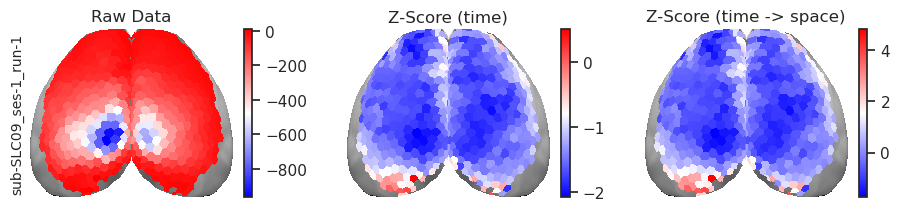

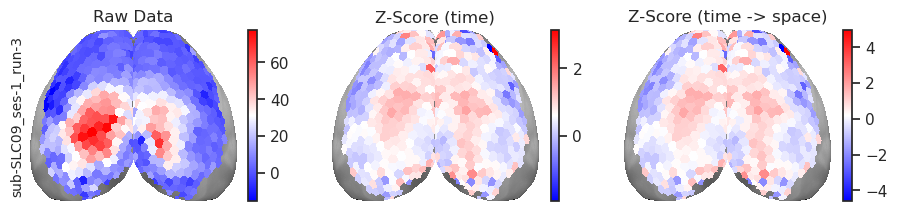

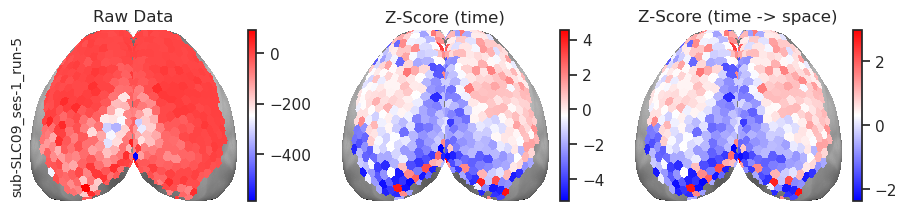

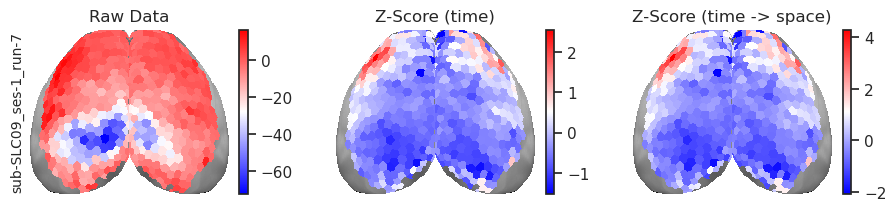

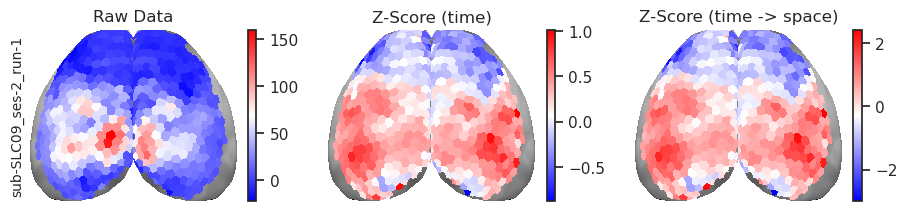

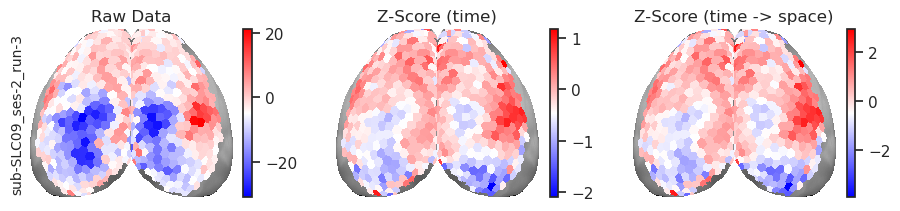

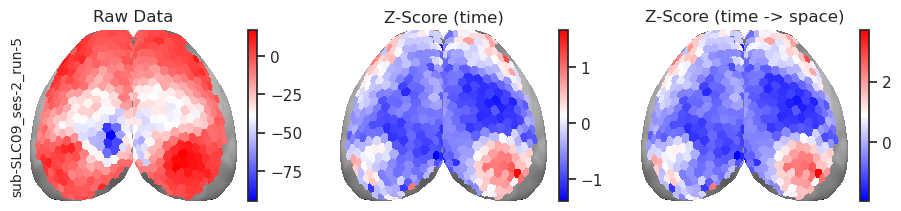

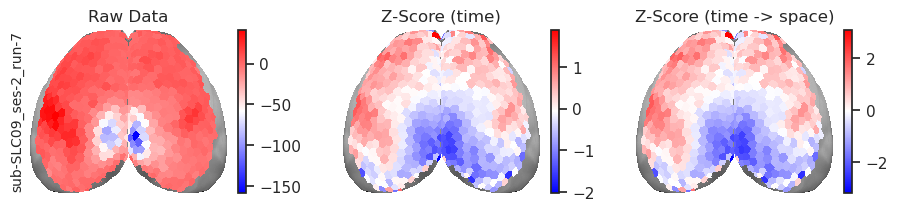

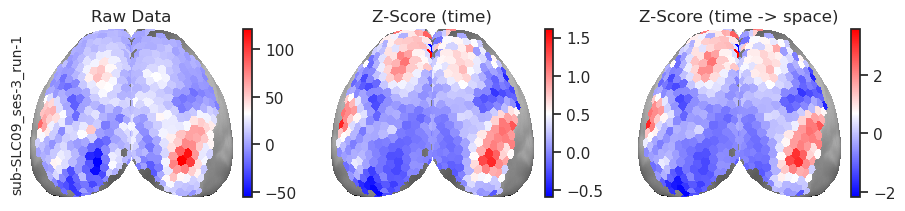

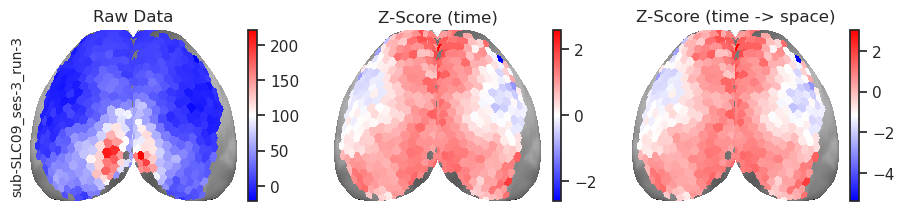

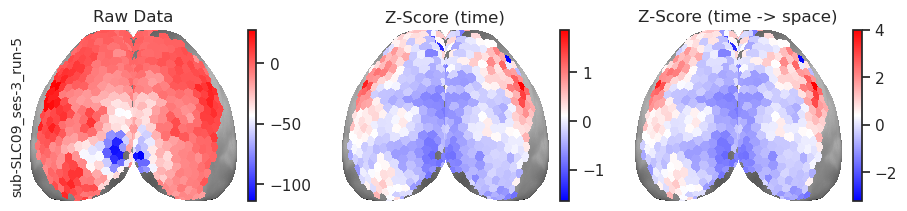

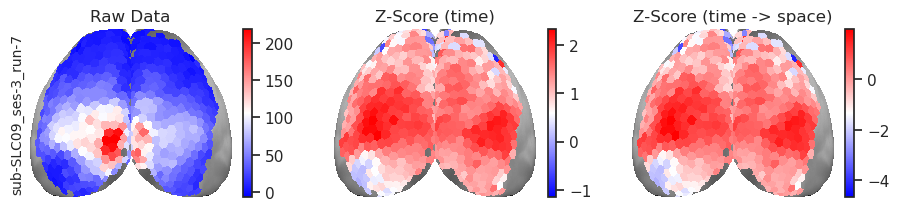

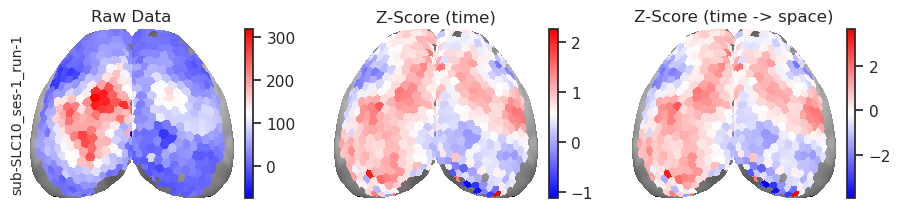

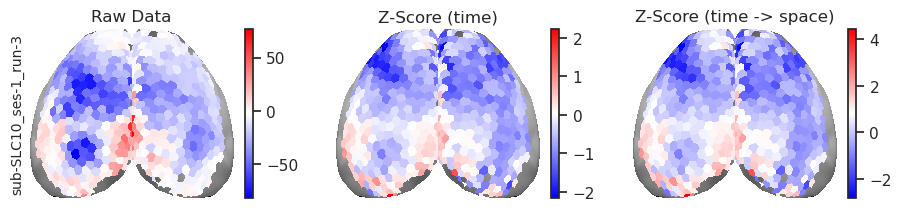

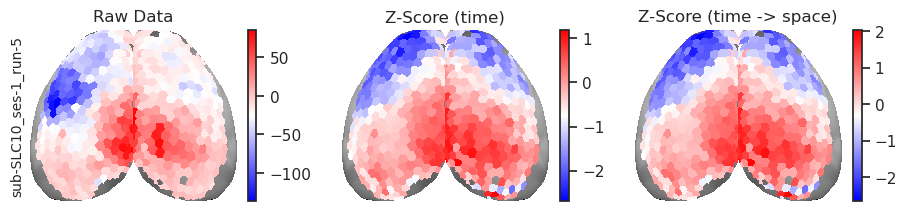

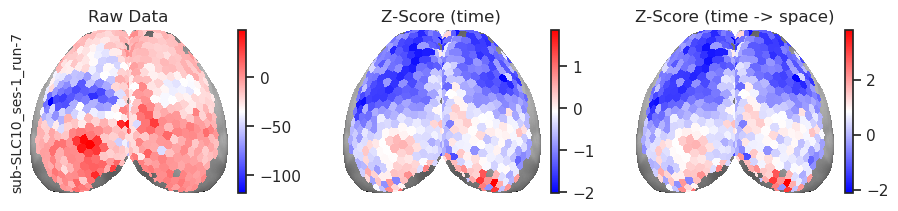

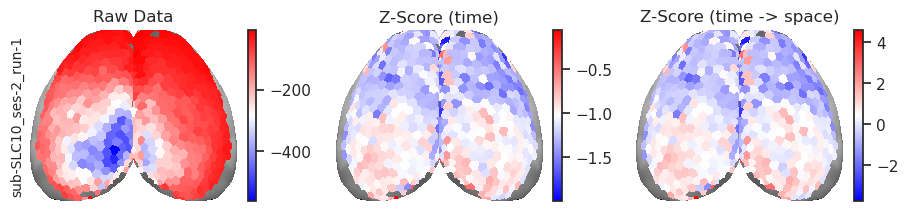

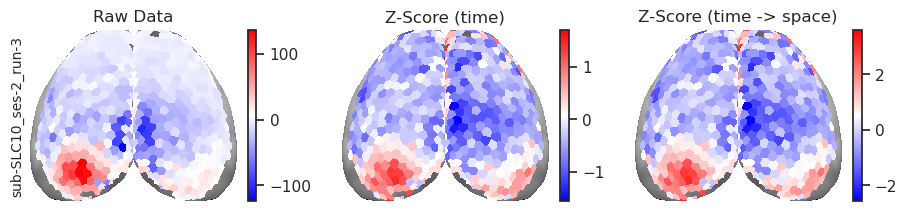

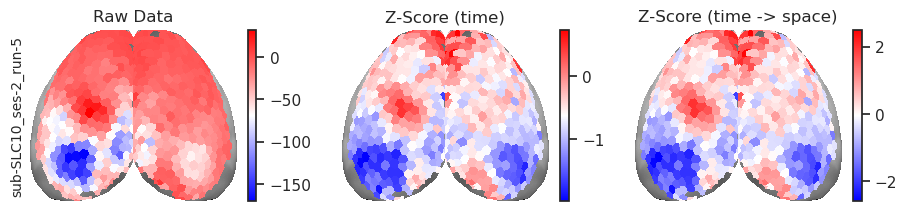

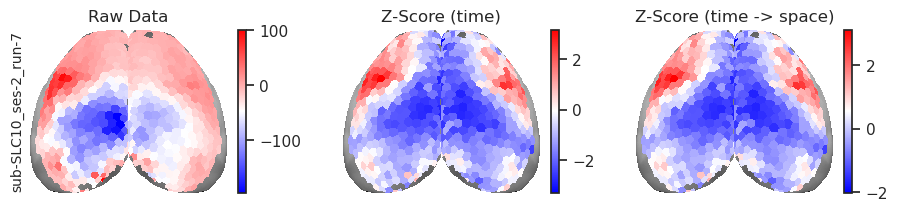

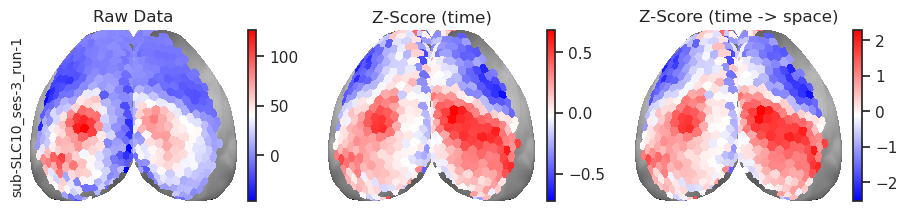

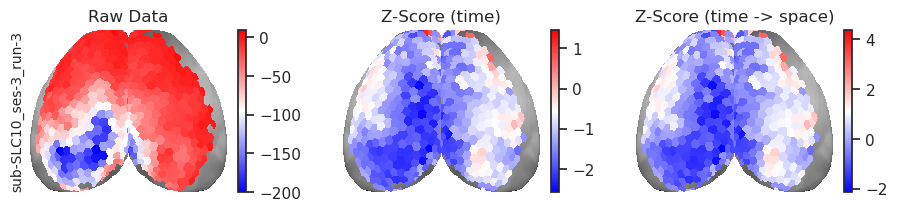

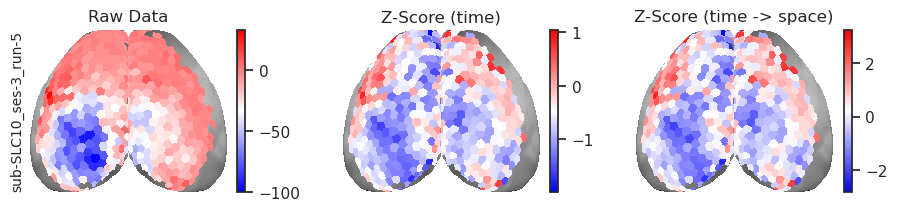

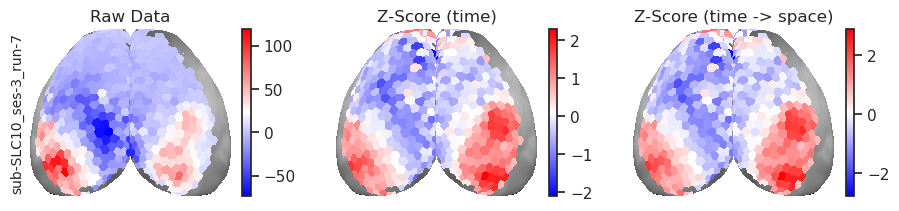

In [112]:
mice.set_kws(band_ca2=(0.01, 0.5))
t = 1200

for key in mice.ca:
    data = Base(mice, key=key, mode='ca2', prep_data=True)
    # data = _normalize_space_time(data.data)
    data = data.data
    data_zt = sp_stats.zscore(data, axis=1)
    data_zst = _normalize_space_time(data)
    
    x2p = np.stack([
        data[:, t],
        data_zt[:, t],
        data_zst[:, t],
        np.isfinite(data[:, t]),
    ])
    x2p, top = bs.trim2d(bs.project_vec(x2p))

    fig, axes = create_figure(1, 3, (9.0, 2.0), 'all', 'all', 'constrained')
    for i, ax in enumerate(axes.flat):
        ax.imshow(mwh(top == 0, top), cmap='Greys_r')
        im = ax.imshow(mwh(~x2p[-1].astype(bool), x2p[i]), cmap='bwr')
        plt.colorbar(im, ax=ax)
    axes[0].set_ylabel(key, fontsize=10)
    axes[0].set_title('Raw Data')
    axes[1].set_title('Z-Score (time)')
    axes[2].set_title('Z-Score (time -> space)')
    remove_ticks(axes)
    plt.show()

<matplotlib.image.AxesImage object at 0x7f1563a12310>

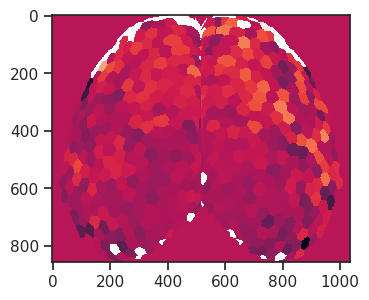

In [76]:
plt.imshow(x2p[2])

In [69]:
mu, sd = {}, {}

data = Base(mice, key=key, mode='bold-lite', prep_data=True)
gamma_raw = _fit_gamma(_normalize_space_time(data.data))
mu['BOLD'] = gamma_raw.mean(0)
sd['BOLD'] = gamma_raw.std(0)

mice.set_kws(band_ca2=(0.01, 0.5))
data = Base(mice, key=key, mode='ca2', prep_data=True)
gamma_raw = _fit_gamma(_normalize_space_time(data.data))
mu['CAS'] = gamma_raw.mean(0)
sd['CAS'] = gamma_raw.std(0)

mice.set_kws(band_ca2=0.5)
data = Base(mice, key=key, mode='ca2', prep_data=True)
gamma_raw = _fit_gamma(_normalize_space_time(data.data))
mu['CAF'] = gamma_raw.mean(0)
sd['CAF'] = gamma_raw.std(0)

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/4880 [00:00<?, ?it/s]

  0%|          | 0/4880 [00:00<?, ?it/s]

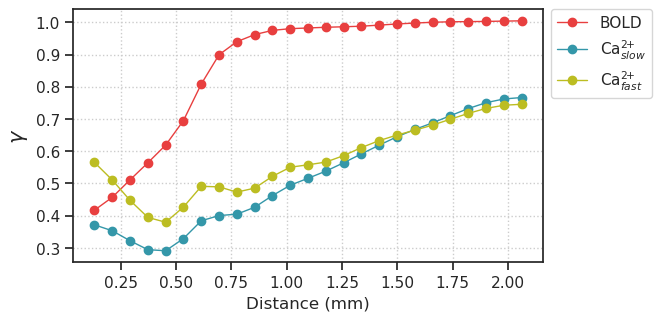

In [70]:
fig, ax = create_figure(1, 1, (6.0, 3.0), sharey='all', layout='constrained')
for i, mode in enumerate(mu):
    ax.plot(
        base.h / 100,
        mu[mode],
        color=pal[translation[mode]],
        label=translation[mode],
        marker='o',
        lw=1,
    )
ax.grid()
ax.legend()
move_legend(ax, (1., 1.03))
ax.set_xlabel('Distance (mm)')
ax.set_ylabel(r'$\gamma$', fontsize=15)

plt.show()

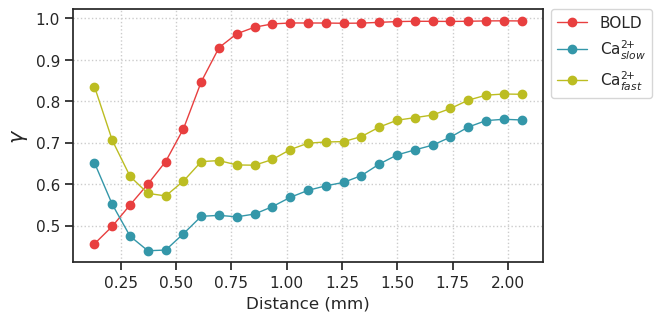

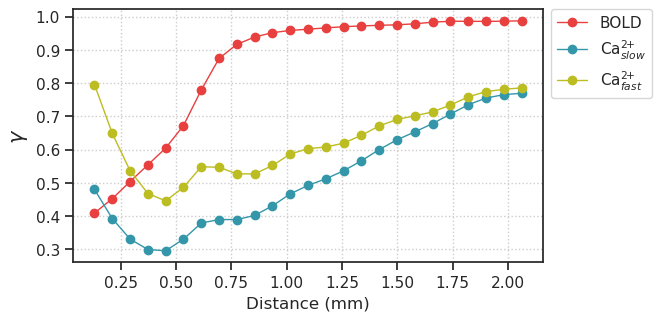

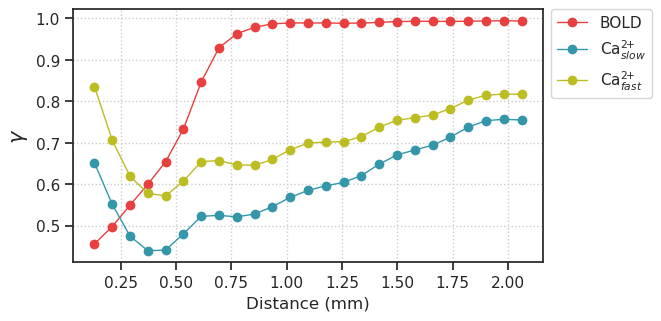

In [80]:
keys_both = sorted(set(mice.bold).intersection(mice.ca))
len(keys_both)

109

## Do all runs

In [81]:
mu = collections.defaultdict(dict)
sd = collections.defaultdict(dict)

for key in tqdm(keys_both):
    data = Base(mice, key=key, mode='bold-lite', prep_data=True)
    gamma_raw = _fit_gamma(_normalize_space_time(data.data))
    mu['BOLD'][key] = gamma_raw.mean(0)
    sd['BOLD'][key] = gamma_raw.std(0)

    mice.set_kws(band_ca2=(0.01, 0.5))
    data = Base(mice, key=key, mode='ca2', prep_data=True)
    gamma_raw = _fit_gamma(_normalize_space_time(data.data))
    mu['CAS'][key] = gamma_raw.mean(0)
    sd['CAS'][key] = gamma_raw.std(0)

    mice.set_kws(band_ca2=0.5)
    data = Base(mice, key=key, mode='ca2', prep_data=True)
    gamma_raw = _fit_gamma(_normalize_space_time(data.data))
    mu['CAF'][key] = gamma_raw.mean(0)
    sd['CAF'][key] = gamma_raw.std(0)

  0%|          | 0/109 [00:00<?, ?it/s]

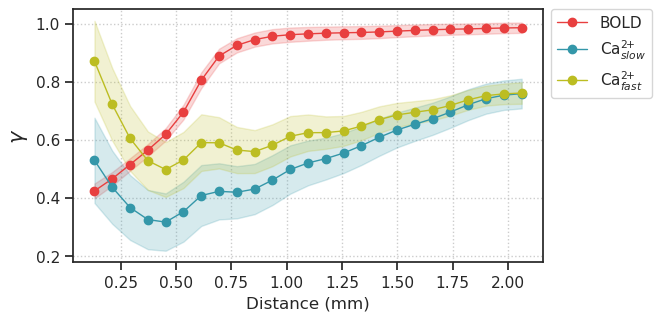

In [90]:
fig, ax = create_figure(1, 1, (6.5, 3.1), sharey='all', layout='constrained')
for i, (mode, d) in enumerate(mu.items()):
    x = np.stack(list(d.values()))
    ax.plot(
        base.h / 100,
        np.mean(x, 0),
        color=pal[translation[mode]],
        label=translation[mode],
        marker='o',
        lw=1,
    )
    ax.fill_between(
        x=base.h / 100,
        y1=np.mean(x, 0) - np.std(x, 0),
        y2=np.mean(x, 0) + np.std(x, 0),
        color=pal[translation[mode]],
        alpha=0.2,
    )
ax.grid()
ax.legend()
move_legend(ax, (1., 1.03))
ax.set_xlabel('Distance (mm)')
ax.set_ylabel(r'$\gamma$', fontsize=15)

plt.show()

In [21]:
mice.set_kws(band_ca2=(0.01, 0.5))
data = Base(mice, key=key, mode='ca2', prep_data=True)
data = _normalize_space_time(data.data)

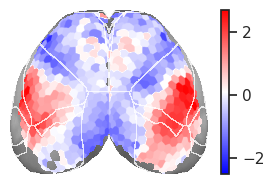

In [22]:
t = 1200
bs.show(
    data[:, t],
    figsize=(3, 2),
    vmin=np.nanmin(data[:, t]),
    vmax=np.nanmax(data[:, t]),
    cmap='bwr',
    cbar=True,
);

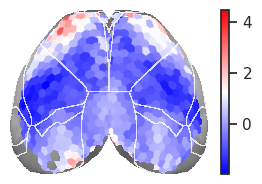

In [23]:
t = 1300
bs.show(
    data[:, t],
    figsize=(3, 2),
    vmin=np.nanmin(data[:, t]),
    vmax=np.nanmax(data[:, t]),
    cmap='bwr',
    cbar=True,
);

In [27]:
key = 'sub-SLC02_ses-1_run-1'

In [28]:
data = Base(mice, key=key, mode='bold-lite', prep_data=True)
data = data.data
# data = _normalize_space_time(data.data)

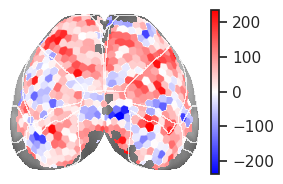

In [31]:
t = 120
bs.show(
    data[:, t],
    figsize=(3, 2),
    vmin=np.nanmin(data[:, t]),
    vmax=np.nanmax(data[:, t]),
    mask_thresh=None,
    cmap='bwr',
    cbar=True,
);

In [32]:
len(data) - np.isnan(data[:, t]).sum()

506

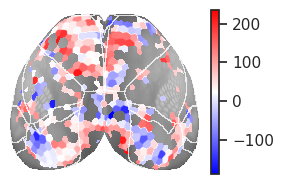

In [33]:
for key in mice.bold:
    data = Base(
        mice,
        key=key,
        mode='bold-lite',
        prep_data=True,
    ).data
    bad = np.isnan(data).sum(1) > 0
    print(bad.sum(), key)

19 sub-SLC01_ses-1_run-1

19 sub-SLC01_ses-1_run-3

22 sub-SLC01_ses-1_run-5

19 sub-SLC01_ses-1_run-7

8 sub-SLC01_ses-2_run-1

8 sub-SLC01_ses-2_run-3

8 sub-SLC01_ses-2_run-5

8 sub-SLC01_ses-2_run-7

12 sub-SLC01_ses-3_run-1

12 sub-SLC01_ses-3_run-3

12 sub-SLC01_ses-3_run-5

12 sub-SLC01_ses-3_run-7

34 sub-SLC02_ses-1_run-1

34 sub-SLC02_ses-1_run-3

34 sub-SLC02_ses-1_run-5

34 sub-SLC02_ses-1_run-7

10 sub-SLC02_ses-2_run-1

10 sub-SLC02_ses-2_run-3

10 sub-SLC02_ses-2_run-5

17 sub-SLC02_ses-3_run-1

17 sub-SLC02_ses-3_run-3

17 sub-SLC02_ses-3_run-5

17 sub-SLC02_ses-3_run-7

20 sub-SLC03_ses-1_run-2

20 sub-SLC03_ses-1_run-4

20 sub-SLC03_ses-1_run-6

7 sub-SLC03_ses-2_run-1

7 sub-SLC03_ses-2_run-3

7 sub-SLC03_ses-2_run-5

7 sub-SLC03_ses-2_run-7

17 sub-SLC03_ses-3_run-1

16 sub-SLC03_ses-3_run-3

16 sub-SLC03_ses-3_run-5

16 sub-SLC03_ses-3_run-7

11 sub-SLC04_ses-1_run-1

11 sub-SLC04_ses-1_run-3

11 sub-SLC04_ses-1_run-5

11 sub-SLC04_ses-1_run-7

6 sub-SLC04_ses-2_run-1

6 sub-SLC04_ses-2_run-3

6 sub-SLC04_ses-2_run-5

7 sub-SLC04_ses-2_run-7

20 sub-SLC04_ses-3_run-1

20 sub-SLC04_ses-3_run-3

20 sub-SLC04_ses-3_run-5

20 sub-SLC04_ses-3_run-7

12 sub-SLC05_ses-1_run-1

12 sub-SLC05_ses-1_run-3

12 sub-SLC05_ses-1_run-7

5 sub-SLC05_ses-2_run-1

4 sub-SLC05_ses-2_run-3

4 sub-SLC05_ses-2_run-5

4 sub-SLC05_ses-2_run-7

16 sub-SLC05_ses-3_run-1

16 sub-SLC05_ses-3_run-3

16 sub-SLC05_ses-3_run-5

16 sub-SLC05_ses-3_run-7

30 sub-SLC06_ses-1_run-1

29 sub-SLC06_ses-1_run-3

30 sub-SLC06_ses-1_run-5

31 sub-SLC06_ses-1_run-7

11 sub-SLC06_ses-2_run-1

11 sub-SLC06_ses-2_run-3

11 sub-SLC06_ses-2_run-5

11 sub-SLC06_ses-2_run-7

26 sub-SLC06_ses-3_run-1

23 sub-SLC06_ses-3_run-3

26 sub-SLC06_ses-3_run-5

22 sub-SLC06_ses-3_run-7

41 sub-SLC07_ses-1_run-1

46 sub-SLC07_ses-1_run-3

42 sub-SLC07_ses-1_run-5

41 sub-SLC07_ses-1_run-7

9 sub-SLC07_ses-2_run-3

9 sub-SLC07_ses-2_run-5

9 sub-SLC07_ses-2_run-7

25 sub-SLC07_ses-3_run-1

25 sub-SLC07_ses-3_run-3

25 sub-SLC07_ses-3_run-5

25 sub-SLC07_ses-3_run-7

18 sub-SLC08_ses-1_run-1

18 sub-SLC08_ses-1_run-3

27 sub-SLC08_ses-1_run-5

9 sub-SLC08_ses-2_run-1

8 sub-SLC08_ses-2_run-3

8 sub-SLC08_ses-2_run-5

8 sub-SLC08_ses-2_run-7

18 sub-SLC08_ses-3_run-1

18 sub-SLC08_ses-3_run-3

18 sub-SLC08_ses-3_run-5

18 sub-SLC08_ses-3_run-7

11 sub-SLC09_ses-1_run-1

11 sub-SLC09_ses-1_run-3

11 sub-SLC09_ses-1_run-5

11 sub-SLC09_ses-1_run-7

7 sub-SLC09_ses-2_run-1

7 sub-SLC09_ses-2_run-3

7 sub-SLC09_ses-2_run-5

7 sub-SLC09_ses-2_run-7

25 sub-SLC09_ses-3_run-1

25 sub-SLC09_ses-3_run-3

26 sub-SLC09_ses-3_run-5

27 sub-SLC09_ses-3_run-7

21 sub-SLC10_ses-1_run-1

21 sub-SLC10_ses-1_run-3

21 sub-SLC10_ses-1_run-7

4 sub-SLC10_ses-2_run-1

4 sub-SLC10_ses-2_run-3

4 sub-SLC10_ses-2_run-5

4 sub-SLC10_ses-2_run-7

6 sub-SLC10_ses-3_run-1

6 sub-SLC10_ses-3_run-3

5 sub-SLC10_ses-3_run-5

5 sub-SLC10_ses-3_run-7

sub-SLC01_ses-1_run-1 61

sub-SLC01_ses-1_run-3 68

sub-SLC01_ses-1_run-5 69

sub-SLC01_ses-1_run-7 72

sub-SLC01_ses-2_run-1 13

sub-SLC01_ses-2_run-3 9

sub-SLC01_ses-2_run-5 12

sub-SLC01_ses-2_run-7 10

sub-SLC01_ses-3_run-1 101

sub-SLC01_ses-3_run-3 100

sub-SLC01_ses-3_run-5 100

sub-SLC01_ses-3_run-7 100

sub-SLC02_ses-1_run-1 178

sub-SLC02_ses-1_run-3 185

sub-SLC02_ses-1_run-5 180

sub-SLC02_ses-1_run-7 179

sub-SLC02_ses-2_run-1 10

sub-SLC02_ses-2_run-3 10

sub-SLC02_ses-2_run-5 14

sub-SLC02_ses-3_run-1 68

sub-SLC02_ses-3_run-3 68

sub-SLC02_ses-3_run-5 70

sub-SLC02_ses-3_run-7 67

sub-SLC03_ses-1_run-2 108

sub-SLC03_ses-1_run-4 105

sub-SLC03_ses-1_run-6 105

sub-SLC03_ses-2_run-1 8

sub-SLC03_ses-2_run-3 10

sub-SLC03_ses-2_run-5 11

sub-SLC03_ses-2_run-7 11

sub-SLC03_ses-3_run-1 157

sub-SLC03_ses-3_run-3 154

sub-SLC03_ses-3_run-5 155

sub-SLC03_ses-3_run-7 152

sub-SLC04_ses-1_run-1 76

sub-SLC04_ses-1_run-3 67

sub-SLC04_ses-1_run-5 70

sub-SLC04_ses-1_run-7 66

sub-SLC04_ses-2_run-1 7

sub-SLC04_ses-2_run-3 9

sub-SLC04_ses-2_run-5 7

sub-SLC04_ses-2_run-7 15

sub-SLC04_ses-3_run-1 101

sub-SLC04_ses-3_run-3 100

sub-SLC04_ses-3_run-5 101

sub-SLC04_ses-3_run-7 102

sub-SLC05_ses-1_run-1 141

sub-SLC05_ses-1_run-3 140

sub-SLC05_ses-1_run-7 144

sub-SLC05_ses-2_run-1 14

sub-SLC05_ses-2_run-3 13

sub-SLC05_ses-2_run-5 6

sub-SLC05_ses-2_run-7 8

sub-SLC05_ses-3_run-1 188

sub-SLC05_ses-3_run-3 186

sub-SLC05_ses-3_run-5 189

sub-SLC05_ses-3_run-7 188

sub-SLC06_ses-1_run-1 159

sub-SLC06_ses-1_run-3 161

sub-SLC06_ses-1_run-5 162

sub-SLC06_ses-1_run-7 153

sub-SLC06_ses-2_run-1 31

sub-SLC06_ses-2_run-3 25

sub-SLC06_ses-2_run-5 13

sub-SLC06_ses-2_run-7 18

sub-SLC06_ses-3_run-1 121

sub-SLC06_ses-3_run-3 111

sub-SLC06_ses-3_run-5 105

sub-SLC06_ses-3_run-7 102

sub-SLC07_ses-1_run-1 157

sub-SLC07_ses-1_run-3 163

sub-SLC07_ses-1_run-5 161

sub-SLC07_ses-1_run-7 160

sub-SLC07_ses-2_run-3 11

sub-SLC07_ses-2_run-5 9

sub-SLC07_ses-2_run-7 10

sub-SLC07_ses-3_run-1 130

sub-SLC07_ses-3_run-3 132

sub-SLC07_ses-3_run-5 130

sub-SLC07_ses-3_run-7 131

sub-SLC08_ses-1_run-1 111

sub-SLC08_ses-1_run-3 115

sub-SLC08_ses-1_run-5 141

sub-SLC08_ses-2_run-1 20

sub-SLC08_ses-2_run-3 10

sub-SLC08_ses-2_run-5 9

sub-SLC08_ses-2_run-7 9

sub-SLC08_ses-3_run-1 140

sub-SLC08_ses-3_run-3 136

sub-SLC08_ses-3_run-5 132

sub-SLC08_ses-3_run-7 134

sub-SLC09_ses-1_run-1 68

sub-SLC09_ses-1_run-3 67

sub-SLC09_ses-1_run-5 72

sub-SLC09_ses-1_run-7 68

sub-SLC09_ses-2_run-1 7

sub-SLC09_ses-2_run-3 7

sub-SLC09_ses-2_run-5 7

sub-SLC09_ses-2_run-7 8

sub-SLC09_ses-3_run-1 182

sub-SLC09_ses-3_run-3 188

sub-SLC09_ses-3_run-5 182

sub-SLC09_ses-3_run-7 188

sub-SLC10_ses-1_run-1 115

sub-SLC10_ses-1_run-3 115

sub-SLC10_ses-1_run-7 117

sub-SLC10_ses-2_run-1 4

sub-SLC10_ses-2_run-3 10

sub-SLC10_ses-2_run-5 6

sub-SLC10_ses-2_run-7 4

sub-SLC10_ses-3_run-1 13

sub-SLC10_ses-3_run-3 10

sub-SLC10_ses-3_run-5 10

sub-SLC10_ses-3_run-7 8

In [39]:
from register.register import Register
reg = Register(mice)

In [46]:
obj = reg.load_obj_masks('sub-SLC07_ses-1', ['eroded', 'brain'])
{
    k: len(unique_idxs(v.numpy()))
    for k, v in obj.items()
}

{'eroded': 5732, 'brain': 5732}

In [47]:
{
    k: len(set(unique_idxs(v.numpy())).intersection(mice.node_lookup['ca2'].values()))
    for k, v in obj.items()
}

{'eroded': 507, 'brain': 507}

In [48]:
obj = reg.load_obj_masks('sub-SLC07_ses-2', ['eroded', 'brain'])
{
    k: len(unique_idxs(v.numpy()))
    for k, v in obj.items()
}

{'eroded': 5967, 'brain': 5967}

In [49]:
{
    k: len(set(unique_idxs(v.numpy())).intersection(mice.node_lookup['ca2'].values()))
    for k, v in obj.items()
}

{'eroded': 532, 'brain': 532}

In [50]:
obj = reg.load_obj_masks('sub-SLC07_ses-3', ['eroded', 'brain'])
{
    k: len(unique_idxs(v.numpy()))
    for k, v in obj.items()
}

{'eroded': 5845, 'brain': 5845}

In [51]:
{
    k: len(set(unique_idxs(v.numpy())).intersection(mice.node_lookup['ca2'].values()))
    for k, v in obj.items()
}

{'eroded': 519, 'brain': 519}